In [1]:
"""author: Vetivert? 💐 
created: 05/06/2025 @ 21:58:06"""

'author: Vetivert? 💐 \ncreated: 05/06/2025 @ 21:58:06'

In [118]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import pandas as pd 
import seaborn as sns 

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, make_scorer, ConfusionMatrixDisplay
import xgboost as xgb
from scipy.stats import randint, uniform

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
# from src.utils.models import *
from src.utils.functions import *

# FUNCTIONS

In [119]:
def distribution_plot(df_x, x_name: str, data_name:str):
    plt.subplots(figsize=(10, 6))
    x_3 = df_x.loc[df_x['Diagnosis'] == 3, x_name]
    x_2 = df_x.loc[df_x['Diagnosis'] == 2, x_name]
    x_1 = df_x.loc[df_x['Diagnosis'] == 1, x_name]
    y_3 = np.random.rand(x_3.shape[0])
    y_2 = np.random.rand(x_2.shape[0])
    y_1 = np.random.rand(x_1.shape[0])

    # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))

    # ax[0].scatter(x_3, np.random.rand(x_3.shape[0]) * 10, color='red', alpha=0.75)
    # ax[0].scatter(x_2, np.random.rand(x_2.shape[0]) * 10, color='navy', alpha=0.75)
    # ax[0].scatter(x_1, np.random.rand(x_1.shape[0]) * 10, color='green', alpha=0.75)
    # ax[0].set_xlabel(x_name + ' Values')
    # ax[0].set_xlim(0, np.max(df_x[x_name]) + 1)
    # ax[0].set_ylim(-0.25, 10.25)
    # ax[0].set_yticks([])

    plt.scatter(x_3, [4/80] * (y_3 + 1), label = 'Diagnosis 3', color='red', alpha=0.65)
    plt.scatter(x_2, [2/80] * (y_2 + 1), label = 'Diagnosis 2',color='navy', alpha=0.65)
    plt.scatter(x_1, [1/80] * (y_1 + 1), label = 'Diagnosis 1',color='green', alpha=0.65)
    plt.vlines(np.max(x_3), 0, (4/80) * (y_3[np.argmax(x_3)]+1), label = f'{np.max(x_3)}: max value of Diagnosis 3', color='red', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_3), 0, (4/80) * (y_3[np.argmin(x_3)]+1), label = f'{np.min(x_3)}: min value of Diagnosis 3', color='red', alpha=0.65, linestyle=":")
    plt.vlines(np.max(x_2), 0, (2/80) * (y_2[np.argmax(x_2)]+1), label = f'{np.max(x_2)}: max value of Diagnosis 2', color='navy', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_2), 0, (2/80) * (y_2[np.argmin(x_2)]+1), label = f'{np.min(x_2)}: min value of Diagnosis 2', color='navy', alpha=0.65, linestyle=":")
    plt.vlines(np.max(x_1), 0, (1/80) * (y_1[np.argmax(x_1)]+1), label = f'{np.max(x_1)}: max value of Diagnosis 1', color='green', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_1), 0, (1/80) * (y_1[np.argmin(x_1)]+1), label = f'{np.min(x_1)}: min value of Diagnosis 1', color='green', alpha=0.65, linestyle=":")
    sns.kdeplot(x_3, color='red')
    sns.kdeplot(x_2, color='navy')
    sns.kdeplot(x_1, color='green')
    plt.legend()
    # plt.xlim(-10, np.max(df_x[x_name]) + 100)
    plt.yticks([])
    plt.title(x_name + ' Distribution by Diagnosis ' + data_name, fontsize=14)
    # plt.colorbar(ticks = [1,2,3], values = [1,2,3], label='Diagnosis')

    # fig.colorbar(cmap=['green','navy','red'], ticks = [1,2,3], values = [1,2,3], ax = ax[0], label='Diagnosis')
    # fig.suptitle(x_name + ' Distribution by Diagnosis', fontsize=16)
    plt.show()

In [120]:
def process_alt_column_array(array):
    """
    Process array with 63 columns (9 groups of 7)
    For each row, find first non-zero group of 7 columns
    """
    group_size = 7
    num_groups = 9  # 63 // 7
    result = np.zeros((array.shape[0], group_size))
    
    # print(f"Processing array shape: {array.shape}")
    # print(f"Groups of {group_size} columns: {num_groups} groups")
    
    for row_idx in range(array.shape[0]):
        # print(f"\nRow {row_idx}:")
        
        for group_idx in range(num_groups):
            start_col = group_idx * group_size
            end_col = start_col + group_size
            
            # Get the group of 7 columns for this row
            group = array[row_idx, start_col:end_col]
            
            # print(f"  Group {group_idx} (cols {start_col}-{end_col-1}): sum={np.sum(group)}")
            
            # If this group is not all zeros, use it
            if not np.all(group == 0):
                result[row_idx] = group
                # print(f"    Using group {group_idx}: {group}")
                break
        else:
            # All groups were zeros, use first group
            result[row_idx] = array[row_idx, :group_size]
            # print(f"    All zeros, using first group: {result[row_idx]}")
    
    return result

# LOAD DATA 2017 + 2019

In [468]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)

df.reset_index(drop=True, inplace=True) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df = df.replace('8(nặng xin về)', 8)
df = df.replace('(17/9)3.7', 3.7)

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
# df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])



# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)
# Get the integer position of the first hematoma column
hematoma_idx = df.columns.get_indexer([HEMATOMA_COLS[0]])[0]
#hematoma_idx.item() -> extract the value from np.int64 into native Python int
df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)
# Get the integer position of the first bleeding column
bleeding_idx = df.columns.get_indexer([BLEEDING_COLS[0]])[0]
df.insert(bleeding_idx.item(), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)
# Get the integer position of the first additional diseases column
additional_diseases_idx = df.columns.get_indexer([ADDITIONAL_DISEASES[0]])[0]
df.insert(additional_diseases_idx.item(), 'additional_diseases', add_diseases['stacked_int'])
# df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)

# df = df.copy()


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': np.float64(56.4), '2': np.float64(39.66), '3': np.float64(3.94)}


/tmp/ipykernel_175906/43879681.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('8(nặng xin về)', 8)
/tmp/ipykernel_175906/43879681.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
/tmp/ipykernel_175906/43879681.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

In [483]:
def distribution_plot(df_x, x_name: str):
    plt.subplots(figsize=(10, 6))
    x_3 = df_x.loc[df_x['Diagnosis'] == 3, x_name]
    x_2 = df_x.loc[df_x['Diagnosis'] == 2, x_name]
    x_1 = df_x.loc[df_x['Diagnosis'] == 1, x_name]
    y_3 = np.random.rand(x_3.shape[0])
    y_2 = np.random.rand(x_2.shape[0])
    y_1 = np.random.rand(x_1.shape[0])

    # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))

    # ax[0].scatter(x_3, np.random.rand(x_3.shape[0]) * 10, color='red', alpha=0.75)
    # ax[0].scatter(x_2, np.random.rand(x_2.shape[0]) * 10, color='navy', alpha=0.75)
    # ax[0].scatter(x_1, np.random.rand(x_1.shape[0]) * 10, color='green', alpha=0.75)
    # ax[0].set_xlabel(x_name + ' Values')
    # ax[0].set_xlim(0, np.max(df_x[x_name]) + 1)
    # ax[0].set_ylim(-0.25, 10.25)
    # ax[0].set_yticks([])

    plt.scatter(x_3, [4/80] * (y_3 + 1), label = 'Diagnosis 3', color='red', alpha=0.65)
    plt.scatter(x_2, [2/80] * (y_2 + 1), label = 'Diagnosis 2',color='navy', alpha=0.65)
    plt.scatter(x_1, [1/80] * (y_1 + 1), label = 'Diagnosis 1',color='green', alpha=0.65)
    plt.vlines(np.max(x_3), 0, (4/80) * (y_3[np.argmax(x_3)]+1), label = f'{np.max(x_3)}: max value of Diagnosis 3', color='red', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_3), 0, (4/80) * (y_3[np.argmin(x_3)]+1), label = f'{np.min(x_3)}: min value of Diagnosis 3', color='red', alpha=0.65, linestyle=":")
    plt.vlines(np.max(x_2), 0, (2/80) * (y_2[np.argmax(x_2)]+1), label = f'{np.max(x_2)}: max value of Diagnosis 2', color='navy', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_2), 0, (2/80) * (y_2[np.argmin(x_2)]+1), label = f'{np.min(x_2)}: min value of Diagnosis 2', color='navy', alpha=0.65, linestyle=":")
    plt.vlines(np.max(x_1), 0, (1/80) * (y_1[np.argmax(x_1)]+1), label = f'{np.max(x_1)}: max value of Diagnosis 1', color='green', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_1), 0, (1/80) * (y_1[np.argmin(x_1)]+1), label = f'{np.min(x_1)}: min value of Diagnosis 1', color='green', alpha=0.65, linestyle=":")
    sns.kdeplot(x_3, color='red')
    sns.kdeplot(x_2, color='navy')
    sns.kdeplot(x_1, color='green')
    plt.legend()
    # plt.xlim(-10, np.max(df_x[x_name]) + 100)
    plt.yticks([])
    plt.title(x_name + ' Distribution by Diagnosis', fontsize=14)
    # plt.colorbar(ticks = [1,2,3], values = [1,2,3], label='Diagnosis')

    # fig.colorbar(cmap=['green','navy','red'], ticks = [1,2,3], values = [1,2,3], ax = ax[0], label='Diagnosis')
    # fig.suptitle(x_name + ' Distribution by Diagnosis', fontsize=16)
    plt.show()

In [122]:
df_PLT = df.loc[:, 'WBC1':'MPV 9'].copy()
df_PLT = df_PLT.drop(['MPV 1','MPV 2','MPV 3','MPV 4', 'MPV 5', 'MPV 6', 'MPV 7', 'MPV 8', 'MPV 9'], axis=1)
df_PLT = df_PLT.replace('(17/9)3.7', 3.7)
df_PLT = df_PLT.replace('(28/6)4.1', 4.1)
df_PLT = df_PLT.replace('(27/11)5.5', 5.5)
df_PLT = df_PLT.replace(' ', np.nan)
# x1_features = df_PLT.columns
for i in df_PLT.columns:
    df_PLT[i] = df_PLT[i].str.replace(',', '.', regex=False).astype(float)
df_PLT.reset_index(drop=True, inplace=True) #reset index
df_PLT.fillna(0, inplace=True) #fill NaN with 0
df_PLT = df_PLT.to_numpy()

# print(df_PLT.shape)
PLT_list = []
PLT_arr = []
for i in range(df_PLT.shape[0]):
    # Extract non-zero elements
    non_zero_elements = df_PLT[i][np.nonzero(df_PLT[i])]
    PLT_list.append(non_zero_elements)
    PLT_arr.append(PLT_list[i][:7])
PLT_arr = np.array(PLT_arr)
print("PLT_arr:", PLT_arr.shape)

df_AST = df.loc[:, 'Glu1':'GGT9'].copy()
df_AST = df_AST.drop(['Bil TP7','Bil TT 7'], axis=1)
df_AST = df_AST.replace('(', np.nan)
df_AST = df_AST.replace('(18/6)7.2', 7.2)
df_AST = df_AST.replace('(8/6)9', 9)
df_AST = df_AST.replace("(11/7)", np.nan)
df_AST = df_AST.replace("(4/12)", np.nan)
df_AST = df_AST.replace(' ', np.nan)
for j in df_AST.columns:
    df_AST[j] = df_AST[j].str.replace(',', '.', regex=False).astype(float)
df_AST.reset_index(drop=True, inplace=True) #reset index
df_AST.fillna(0, inplace=True) #fill NaN with 0
df_AST = df_AST.to_numpy()

AST_list = []
AST_arr = []

max_len = 7
for i in range(df_AST.shape[0]):
    # Extract non-zero elements
    non_zero_elements = df_AST[i][np.nonzero(df_AST[i])]
    # Pad or truncate to fixed length
    if len(non_zero_elements) >= max_len:
        AST_arr.append(non_zero_elements[:max_len])  # Truncate if too long
    else:
        # Pad with zeros if too short
        padded = np.zeros(max_len)
        padded[:len(non_zero_elements)] = non_zero_elements
        AST_arr.append(padded)

AST_arr = np.array(AST_arr)
# print(AST_arr.shape)
print(f"AST_arr: {AST_arr.shape}")

PLT_column_names = ['WBC1','N1','L1','RBC1','Hb1','HCT1','PLT1']
AST_column_names = ['Glu1','Ure1','Cre1','Alb1','AST1','ALT1','GGT1']

df_symptoms = df.loc[:, 'Diagnosis':'Oliguria'].copy()

for i, col_name in enumerate(PLT_column_names):
    df_symptoms[col_name] = PLT_arr[:, i]
for i, col_name in enumerate(AST_column_names):
    df_symptoms[col_name] = AST_arr[:, i]

# df_symptoms

PLT_arr: (406, 7)
AST_arr: (406, 7)


In [123]:
# df_symptoms.columns
df_symptoms = df_symptoms[~((df_symptoms['AST1'] == 0) & (df_symptoms['ALT1'] == 0))]

df_symptoms

,Diagnosis,Gende,DHF infection His.,additional_diseases,Fever,Bleeding,Fatigue,Day of illness,Level of temp,Duration fever,...,Hb1,HCT1,PLT1,Glu1,Ure1,Cre1,Alb1,AST1,ALT1,GGT1
3,2,1,0,1,1,1,0,5,NaN,NaN,...,158.0,0.461,59.0,3.16,3.30,88.0,292.40,240.2,22.5,224.1
4,1,1,0,1,1,0,1,4,NaN,NaN,...,126.0,0.470,67.0,5.30,4.30,95.0,63.30,32.0,0.0,0.0
5,1,0,0,1,1,0,1,3,3,6,...,136.0,0.392,146.0,7.30,2.10,78.0,41.00,75.2,46.8,49.7
6,2,0,0,0,1,1,0,4,NaN,NaN,...,128.0,0.375,156.0,7.29,3.30,86.0,37.30,70.7,37.5,18.3
7,2,0,0,1,1,0,0,3,NaN,NaN,...,124.0,0.353,63.0,7.71,3.70,77.0,35.10,51.9,41.0,52.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,2,0,0,1,1,1,1,4,2,6,...,129.0,0.370,74.0,6.80,3.00,64.0,54.00,26.0,0.0,0.0
402,2,0,0,1,1,0,1,5,3,6,...,136.0,0.410,55.0,6.30,2.20,70.0,67.00,65.0,0.0,0.0
403,1,1,0,0,1,0,1,6,3,7,...,147.0,0.470,65.0,78.00,23.00,24.0,5.09,3.9,86.0,40.0
404,2,1,0,1,1,0,1,7,3,7,...,158.0,0.440,7.0,7.90,5.80,93.0,82.00,43.0,80.0,0.0


In [124]:
df_symptoms.columns

Index(['Diagnosis', 'Gende', 'DHF infection His.', 'additional_diseases',
       'Fever', 'Bleeding', 'Fatigue', 'Day of illness', 'Level of temp',
       'Duration fever', 'Pulse rate', 'Systolic BP', 'Diastolic BP',
       'Headache', 'Body ache', 'Rash', 'hematoma', 'Mucosa membrane bleeding',
       'Pleural effusion', 'Ascites', 'Pericardial effusion', 'Vomiting',
       'Abdominal pain or tendness', 'Liver enlargement', 'Oliguria', 'WBC1',
       'N1', 'L1', 'RBC1', 'Hb1', 'HCT1', 'PLT1', 'Glu1', 'Ure1', 'Cre1',
       'Alb1', 'AST1', 'ALT1', 'GGT1'],
      dtype='object')

# LOAD DATA 2025

In [7]:
df_2025 = pd.read_csv(DATA_PATH_2025, sep=",", header=0, nrows = 125) #separator is ;

In [8]:
# df_2025.dtypes
df_2025

,STT,Số bệnh án,Họ & tên,Năm sinh,Tuổi,Giới tính,Chẩn đoán,Cân nặng,Chiều cao,BMI,...,CRE,BILI-TP,BILI-TT,ALBUMUN,Glucose,MaBenhpham,IgG,IgM,KN B19,NestedPCR
0,1,22043345,Võ Minh Trọng,2003,19,1,Sốt xuất huyết Dengue N3 có DHCB/ Rối loạn điệ...,57.0,168.0,20.195578,...,80.7,7.9,2.4,34.1,NaN,DEN1,0,0,0,0
1,2,22042989,Trương Văn Đức,1999,23,1,Sốt xuất huyết Dengue/ Viêm loét dạ dày- tá tr...,90.0,167.0,32.270788,...,84.7,8.2,1.9,NaN,6.0,DEN2,0,0,0,0
2,3,22043439,Tăng Thế Anh Hoàng,2002,20,1,Sốt xuất huyết Dengue/ Viêm gan nhiễm độc/ viê...,70.0,170.0,24.221453,...,NaN,NaN,NaN,NaN,NaN,DEN3,0,0,0,0
3,4,22042233,Đặng Thái Phong,1999,23,1,Sốt nhiễm khuẩn/ Nhiễm khuẩn huyết đường vào t...,53.0,174.0,17.505615,...,124.6,22.5,10.4,NaN,5.4,DEN4,0,0,0,0
4,5,22043566,Phạm Mạnh Cường,1984,38,1,Sốt xuất huyết Dengue có DHCB/ Viêm dạ dày - t...,60.0,170.0,20.761246,...,130.5,19.2,4.2,NaN,NaN,DEN5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,121,22058520,Phan Thị Phượng,1985,37,2,Sốt xuất huyết Dengue có DHCB/Tăng men gan,54.0,155.0,22.476587,...,NaN,NaN,NaN,NaN,NaN,DEN121,1,0,0,0
121,122,22058492,Lê Thị Danh,1984,38,2,Sốt xuất huyết Dengue có DHCB,46.0,153.0,19.650562,...,77.2,7.4,2.0,30.9,6.6,DEN122,0,0,0,0
122,123,22058741,Nguyễn Thị Thu,1975,47,2,Sốt xuất huyết Dengue/ Viêm gan nhiễm độc/ rối...,NaN,NaN,NaN,...,78.8,12.1,3.5,32.3,4.3,DEN123,0,0,0,0
123,124,22058461,Nguyễn Thị Hạnh,1971,51,2,Sốt siêu vi/viêm loét DD-TT/ trào ngược dạ dày...,50.0,150.0,22.222222,...,69.9,6.1,0.8,36.4,9.6,DEN124,0,0,0,0


In [9]:
df_test = df_2025.loc[:, 'Mạch':'ALT'].copy()

In [10]:
df_test

,Mạch,THA,HATT,HATTr,WBC,NEU,%NEU,LYM,%LYM,RBC,HGB,HCT,PLT,AST,ALT
0,98.0,0,118.0,73.0,2.9,2.1,72.0,0.5,16.8,5.17,15.2,43.9,76,120.5,45.9
1,114.0,0,120.0,70.0,2.2,1.1,49.0,0.6,26.7,5.29,15.2,44.9,62,401.1,263.3
2,104.0,0,112.0,76.0,4.6,3.8,82.4,0.2,4.7,4.41,13.2,39.3,144,16.8,15.5
3,108.0,0,88.0,56.0,6.8,6.3,93.5,0.2,2.8,4.22,12.6,38.1,118,48.9,29.7
4,80.0,0,120.0,70.0,6.6,1.3,19.2,2.1,32.1,5.31,15.9,46.9,14,66.2,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,89.0,0,100.0,60.0,3.3,1.1,32.8,1.4,42.3,4.95,14.0,42.3,27,NaN,NaN
121,80.0,0,110.0,70.0,3.6,1.7,46.9,1.0,27.7,5.85,16.3,49.6,8,78.5,41.3
122,NaN,0,NaN,NaN,3.1,1.7,54.5,0.6,26.1,4.34,12.9,38.4,28,214.4,125.2
123,89.0,0,101.0,70.0,3.5,1.6,45.6,1.5,43.1,4.14,11.7,35.4,161,23.8,24.9


# LOAD DATA SAMPLES

In [469]:
df_samples = pd.read_csv(DATA_PATH_SAMPLES, sep=",", header=0, nrows = 279) #separator is ;

df_samples.drop(['Oder No', 'Age', 'Samp No', 'Fiver', 'bleeding place','NS1','IgG','IgM'], inplace=True, axis=1)
df_samples = df_samples.replace('110,0', 111.0)
df_samples['Vomiting'] = df_samples['Vomiting'].fillna(0)
df_samples["PLT"] = pd.to_numeric(df_samples["PLT"])
#
df_samples = df_samples.dropna() #remove NA elements in AST/ALT



In [8]:
# df_samples
df_samples.dtypes

# df_samples.isnull().sum()


Gende               int64
Diagnosis           int64
day of symtoms      int64
GOT               float64
GPT               float64
RBC               float64
WBC               float64
PLT               float64
HCT               float64
bleeding            int64
Vomiting          float64
headache            int64
bodyache            int64
dtype: object

In [13]:
# Sample data
X = df_samples.drop(columns=['Diagnosis']).values
Y = df_samples['Diagnosis'].values.ravel()

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

rf_model = RandomForestClassifier()

accuracies = []

# Stratified K-Fold loop
for train_index, val_index in skf.split(X, Y):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    rf_model.fit(X_train, Y_train)
    preds = rf_model.predict(X_val)
    acc = accuracy_score(Y_val, preds)
    accuracies.append(acc)

print(f"Cross-validated accuracy scores: {accuracies}")
print(f"Mean accuracy: {np.mean(accuracies):.4f}")

/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Cross-validated accuracy scores: [0.72, 0.96, 0.68, 0.84, 0.72, 0.68, 0.6, 0.84, 0.7083333333333334, 0.5833333333333334]
Mean accuracy: 0.7332


In [14]:
param_grid = {'n_estimators': [50, 75, 100, 200], 'max_depth': [3, 7, 9, 15], 'min_samples_split': [2, 5, 10, 12 ], 'min_samples_leaf': [1, 2, 4,6,8], 'max_features': ['sqrt', 'log2']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
grid.fit(X, Y)

print(grid.best_params_)
print(grid.best_score_)

/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import joblib

# Save the model
joblib.dump(grid.best_estimator_, 'RF_2025_076.pkl')

['RF_2025_076.pkl']

Index(['Gende', 'day of symtoms', 'GOT', 'GPT', 'RBC', 'WBC', 'PLT', 'HCT',
       'NS1', 'IgG', 'IgM', 'bleeding', 'Vomiting', 'headache', 'bodyache'],
      dtype='object')


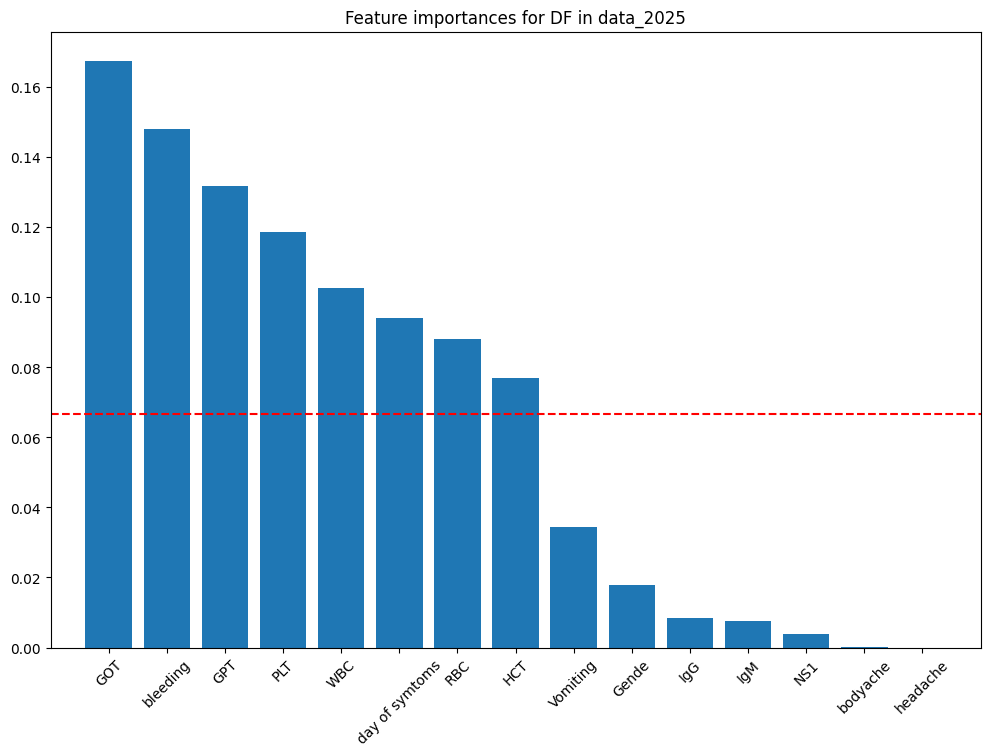

In [ ]:
# Classification report
# print("\nClassification Report:")
# print(classification_report(YA_test, YA_pred))

# uniques, counts = np.unique(YA_pred, return_counts=True)
# print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(YA_pred), 2))))

# Plotting feature importances
features = df_samples.drop(columns=['Diagnosis']).columns
print(features)
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances for DF in data_2025")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

In [ ]:

x1_train, x1_test, y1_train, y1_test = train_test_split(X, Y, \
                                                    test_size=0.2, random_state=17, stratify=Y)
x1_features = df_samples.drop(columns=['Diagnosis']).columns

# x1_train, x1_test, y1_train, y1_test = x1_train.to_numpy(), x1_test.to_numpy(), y1_train.to_numpy(), y1_test.to_numpy()

print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

x1_train shape:  (191, 15) y1_train shape:  (191,)
x1_test shape:  (48, 15) y1_test shape:  (48,)
percentage of classes:  {np.int64(1): np.float64(62.5), np.int64(2): np.float64(35.42), np.int64(3): np.float64(2.08)}


In [ ]:
# Convert class labels from 1-based (1,2,3) to 0-based (0,1,2) for XGBoost
y1_train_0based = y1_train - 1
y1_test_0based = y1_test - 1

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    eval_metric='error'
)

xgb_model.fit(x1_train, y1_train_0based)

# When predicting later, remember to add +1 to convert back to original classes

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

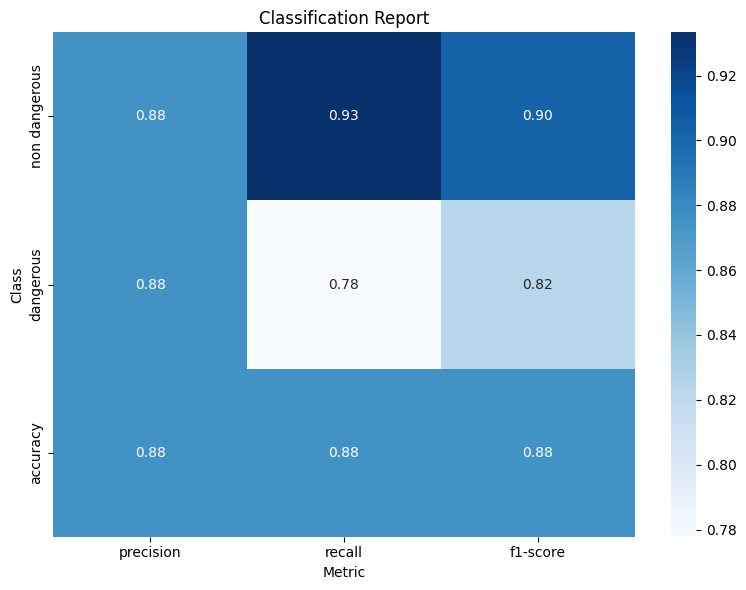

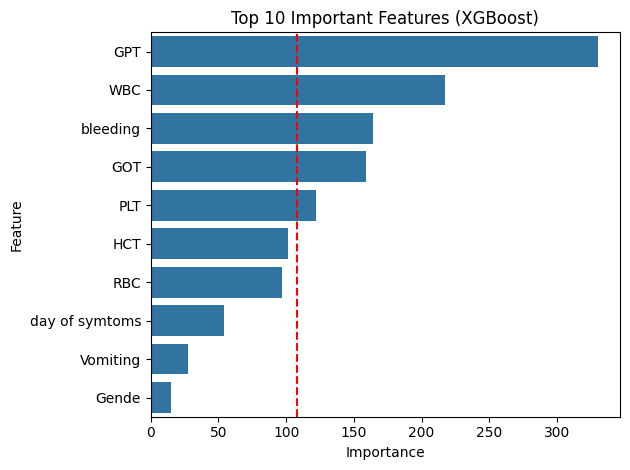

In [ ]:
evaluate(xgb_model, x1_test, y1_test_0based)
gain_importances_df = plot_feature_importance(xgb_model, x1_features, importance_type='total_gain')

In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.1, 0.2]
}

# search = RandomizedSearchCV(xgb.XGBClassifier(), param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy', verbose=1)
search = GridSearchCV(xgb_model, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
search.fit(x1_train, y1_train_0based)
print("Best parameters:", search.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}


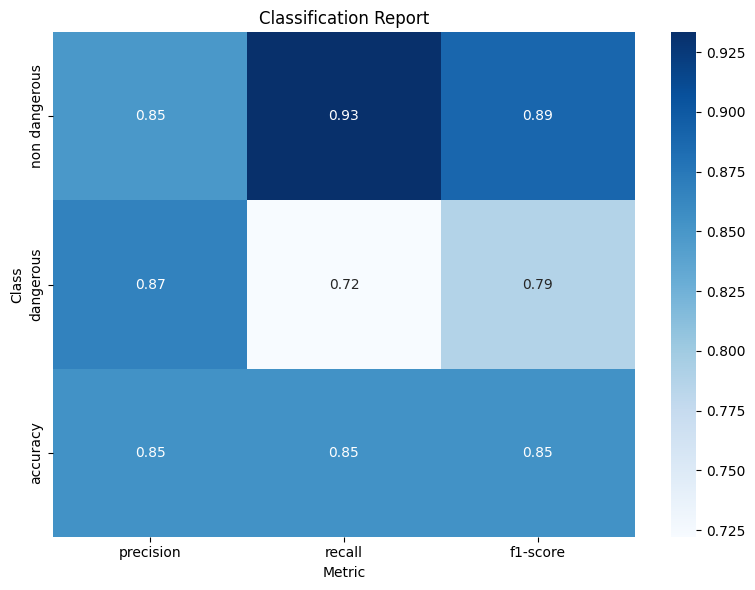

{'accuracy': 0.8541666666666666,
 'precision': 0.8666666666666667,
 'recall': 0.7222222222222222,
 'f1_score': 0.7878787878787878,
 'roc_auc': np.float64(0.8444444444444444)}

In [ ]:
xgb_grid = search.best_estimator_
evaluate(xgb_grid, x1_test, y1_test_0based)

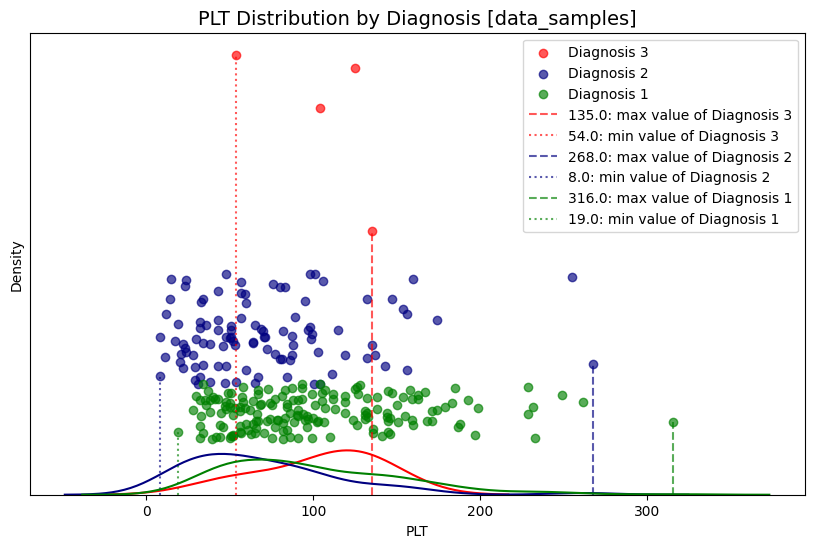

In [ ]:
distribution_plot(df_samples, 'PLT', data_name = '[data_samples]')

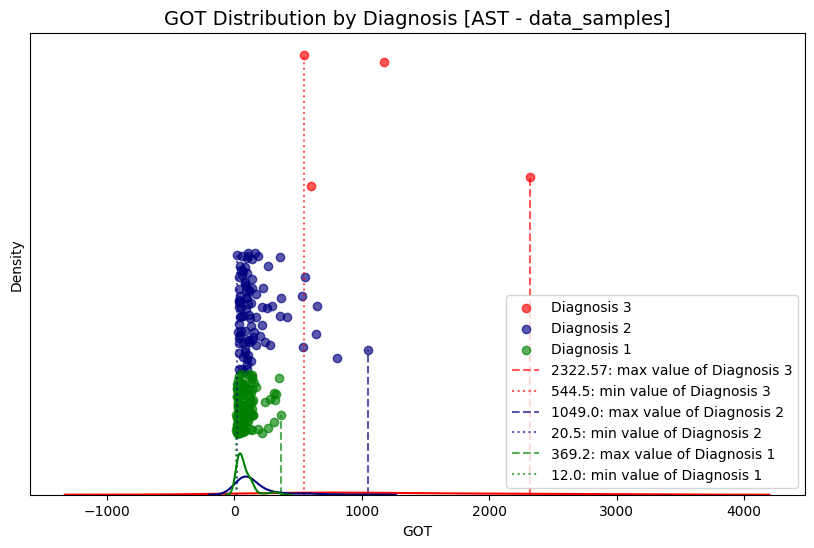

In [ ]:
distribution_plot(df_samples, 'GOT', data_name = '[AST - data_samples]')

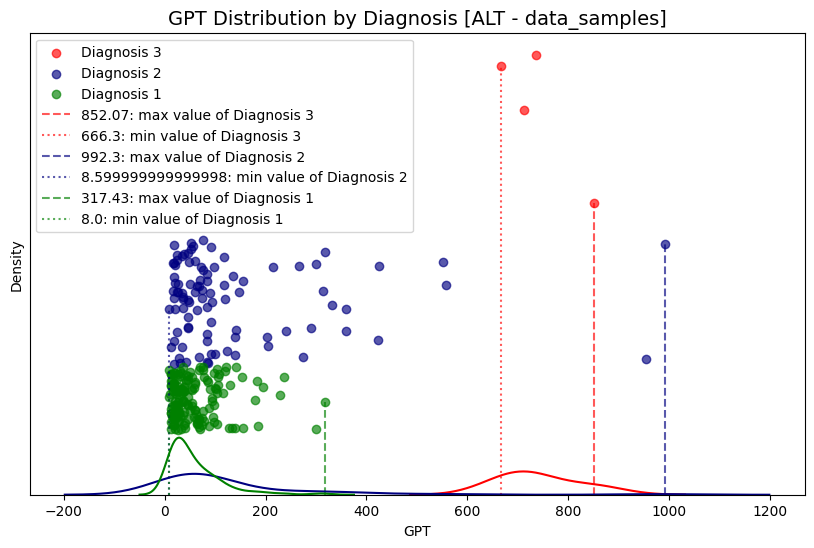

In [ ]:
distribution_plot(df_samples, 'GPT', data_name = '[ALT - data_samples]')

In [ ]:
df_samples

,Gende,Diagnosis,day of symtoms,GOT,GPT,RBC,WBC,PLT,HCT,NS1,IgG,IgM,bleeding,bleeding place,Vomiting,headache,bodyache
0,1,2,5,292.4,240.2,4.890,1.39,46.00,0.440,1.0,1.0,1.0,1,2,0.0,1,1
1,0,1,4,68.4,97.3,4.250,2.40,79.00,0.371,1.0,0.0,0.0,0,0,0.0,1,1
4,0,2,6,20.5,12.3,4.944,4.20,38.01,0.440,1.0,0.0,0.0,1,2,0.0,1,1
6,1,1,5,63.3,32.0,4.900,4.10,67.00,0.470,1.0,0.0,0.0,0,0,0.0,1,1
7,0,1,3,75.2,46.8,4.590,2.44,146.00,0.392,1.0,0.0,0.0,0,0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0,1,5,123.9,57.5,4.608,2.99,34.85,0.400,1.0,0.0,0.0,0,0,0.0,1,1
275,1,1,2,22.6,14.6,4.300,3.65,138.00,0.382,1.0,0.0,0.0,0,0,0.0,1,1
276,0,1,5,77.5,59.9,3.390,3.08,141.00,0.293,1.0,0.0,0.0,0,0,0.0,1,1
277,0,1,6,129.8,75.9,4.430,2.90,61.00,0.365,1.0,0.0,0.0,0,0,0.0,1,1


# CASE 1: Data 2017/2019 + Data_samples (with symptoms)

In [517]:
df_x = pd.DataFrame(X, columns=features)
features

['Diagnosis',
 'Gende',
 'DHF infection His.',
 'additional_diseases',
 'Fever',
 'Bleeding',
 'Fatigue',
 'Day of illness',
 'Level of temp',
 'Duration fever',
 'Pulse rate',
 'Systolic BP',
 'Diastolic BP',
 'Headache',
 'Body ache',
 'Rash',
 'hematoma',
 'Mucosa membrane bleeding',
 'Pleural effusion',
 'Ascites',
 'Pericardial effusion',
 'Vomiting',
 'Abdominal pain or tendness',
 'Liver enlargement',
 'Oliguria',
 'WBC',
 'N',
 'L',
 'RBC',
 'Hb',
 'HCT',
 'PLT',
 'Glu',
 'Ure',
 'Cre',
 'Alb',
 'AST',
 'ALT',
 'GGT']

In [525]:
df_samples = df_samples.rename(columns={
    'day of symtoms': 'Day of illness',
    'AST1': 'AST',
    'ALT1': 'ALT',
    'RBC1': 'RBC',
    'WBC1': 'WBC',
    'PLT1': 'PLT',
    'HCT1': 'HCT',
    'bleeding': 'Bleeding',
    'headache': 'Headache',
    'bodyache': 'Body ache',
})
df_samples.columns

Index(['Gende', 'Diagnosis', 'Day of illness', 'AST', 'ALT', 'RBC', 'WBC',
       'PLT', 'HCT', 'Bleeding', 'Vomiting', 'Headache', 'Body ache'],
      dtype='object')

In [526]:
df_xs = df_x[df_samples.columns].copy()
df_xs

,Gende,Diagnosis,Day of illness,AST,ALT,RBC,WBC,PLT,HCT,Bleeding,Vomiting,Headache,Body ache
0,1.0,2.0,5.0,292.4,240.2,5.04,1.45,59.0,0.461,1.0,0.0,1.0,1.0
1,1.0,1.0,4.0,63.3,32.0,4.90,4.10,67.0,0.470,0.0,0.0,1.0,1.0
2,0.0,1.0,3.0,75.2,46.8,4.59,2.44,146.0,0.392,0.0,1.0,1.0,1.0
3,0.0,2.0,4.0,70.7,37.5,3.94,4.50,156.0,0.375,1.0,1.0,1.0,1.0
4,0.0,2.0,3.0,51.9,41.0,3.88,2.32,63.0,0.353,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0.0,2.0,4.0,54.0,26.0,4.40,2.44,74.0,0.370,1.0,0.0,1.0,1.0
346,0.0,2.0,5.0,67.0,65.0,4.30,4.60,55.0,0.410,0.0,1.0,1.0,1.0
347,1.0,1.0,6.0,78.0,23.0,5.40,1.60,65.0,0.470,0.0,0.0,1.0,0.0
348,1.0,2.0,7.0,82.0,43.0,5.10,5.90,7.0,0.440,0.0,0.0,1.0,1.0


In [527]:
df_xs = pd.concat([df_xs, df_samples], axis=0, ignore_index=True)

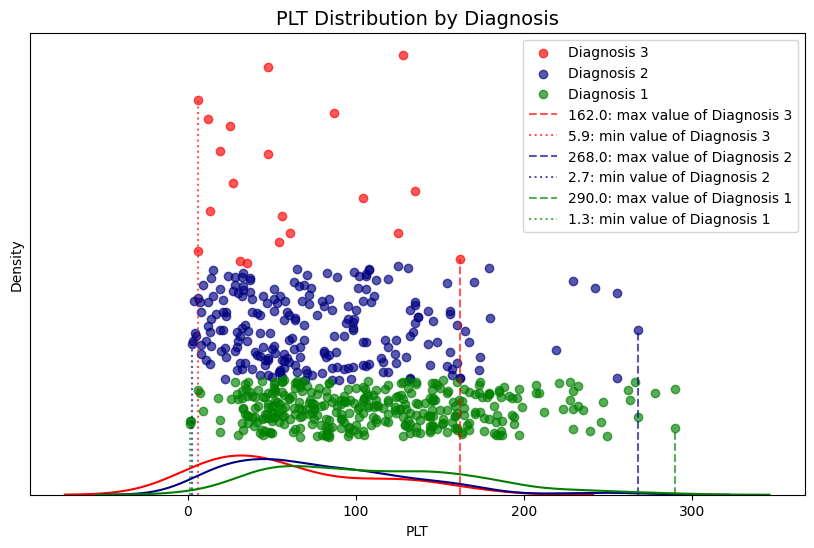

In [528]:
distribution_plot(df_xs, 'PLT')

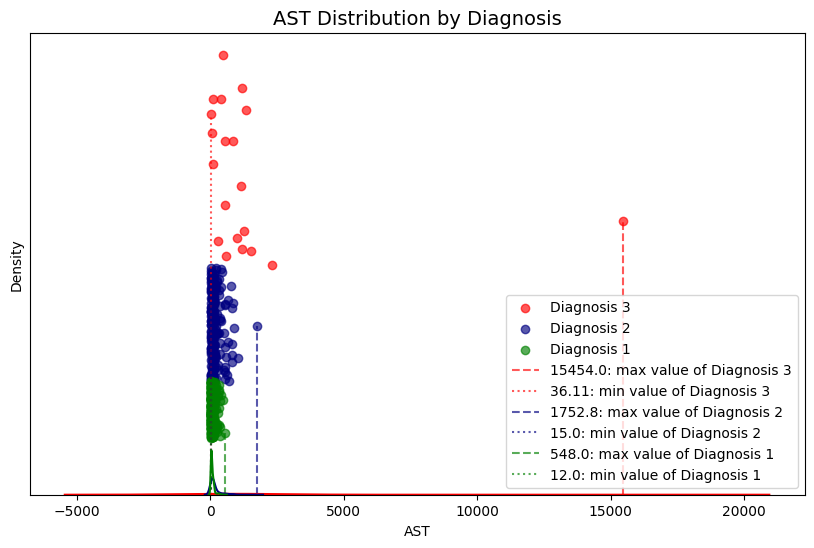

In [532]:
distribution_plot(df_xs, 'AST')

In [485]:
features = ['Gende','Diagnosis','Day of illness','AST1','ALT1','RBC1','WBC1','PLT1','HCT1','Bleeding','Vomiting','Headache','Body ache']
df_case1 = df_symptoms[features].copy()

df_samples = df_samples.rename(columns={
    'day of symtoms': 'Day of illness',
    'GOT': 'AST1',
    'GPT': 'ALT1',
    'RBC': 'RBC1',
    'WBC': 'WBC1',
    'PLT': 'PLT1',
    'HCT': 'HCT1',
    'bleeding': 'Bleeding',
    'headache': 'Headache',
    'bodyache': 'Body ache',
})

df_case1 = pd.concat([df_case1, df_samples], axis=0, ignore_index=True)
# df_case1['Diagnosis'] = np.where(df_case1['Diagnosis'] == '3', '2', df_case1['Diagnosis'])
# df_case1['Diagnosis'] = np.where(df_case1['Diagnosis'] == 3, '2', df_case1['Diagnosis'])

df_case1

,Gende,Diagnosis,Day of illness,AST1,ALT1,RBC1,WBC1,PLT1,HCT1,Bleeding,Vomiting,Headache,Body ache
0,1,2,5,240.2,22.5,5.040,1.45,59.00,0.461,1,0,1,1
1,1,1,4,32.0,0.0,4.900,4.10,67.00,0.470,0,0,1,1
2,0,1,3,75.2,46.8,4.590,2.44,146.00,0.392,0,1,1,1
3,0,2,4,70.7,37.5,3.940,4.50,156.00,0.375,1,1,1,1
4,0,2,3,51.9,41.0,3.880,2.32,63.00,0.353,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,0,1,5,123.9,57.5,4.608,2.99,34.85,0.400,0,0.0,1,1
591,1,1,2,22.6,14.6,4.300,3.65,138.00,0.382,0,0.0,1,1
592,0,1,5,77.5,59.9,3.390,3.08,141.00,0.293,0,0.0,1,1
593,0,1,6,129.8,75.9,4.430,2.90,61.00,0.365,0,0.0,1,1


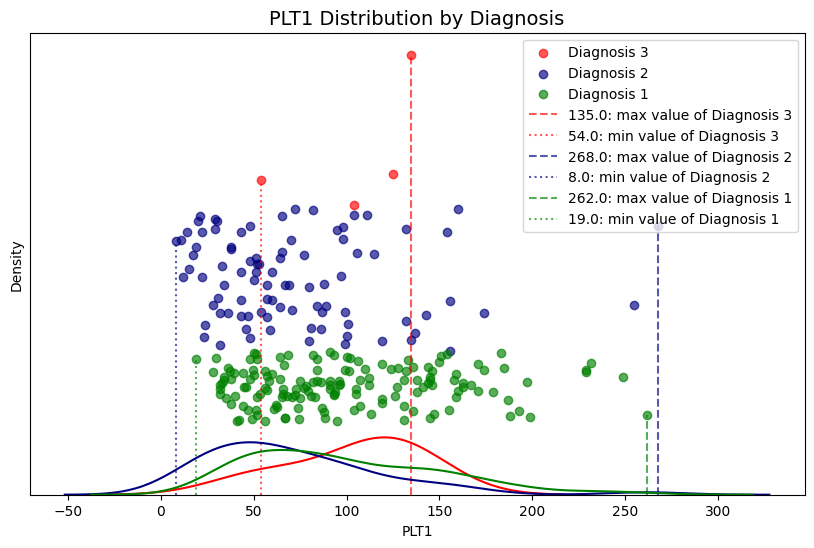

In [487]:
distribution_plot(df_case1, 'PLT1')

### RF - df_Case_1

In [459]:
diag_symptoms = df_case1['Diagnosis']
df_case1.drop(columns=['Diagnosis'], inplace=True)


In [408]:
df_case1.describe()

,AST1,ALT1,RBC1,WBC1,PLT1,HCT1
count,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000
mean,135.450269,93.827160,7.326106,4.344405,97.587882,3.623440
std,654.594330,268.672398,18.579139,3.655773,60.348596,23.926035
min,2.870000,0.000000,2.880000,1.000000,1.300000,0.239000
25%,31.500000,17.630000,4.300000,2.535000,50.000000,0.371000
50%,57.630000,39.000000,4.630000,3.580000,87.000000,0.405000
75%,112.800000,83.600000,5.080000,5.215000,137.000000,0.440000
max,15454.000000,5254.000000,162.000000,72.000000,290.000000,283.000000


In [355]:
df_case1.fillna(0, inplace=True) #fill NaN with 0

In [371]:
df_case1.isnull().sum()

Gende             0
Day of illness    0
AST1              0
ALT1              0
RBC1              0
WBC1              0
PLT1              0
HCT1              0
Bleeding          0
Vomiting          0
Headache          0
Body ache         0
dtype: int64

In [460]:
X = df_case1.to_numpy()
Y = diag_symptoms.to_numpy()
features = df_case1.columns


In [461]:
X = X.astype(float)
Y = Y.astype(int)
print(X.dtype)
print(Y.dtype)

uniques, counts = np.unique(Y, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(Y), 2))))

float64
int64
percentage of classes:  {np.int64(1): np.float64(58.32), np.int64(2): np.float64(41.68)}


In [369]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

rf_model = RandomForestClassifier(max_depth=37, max_features='sqrt', min_samples_leaf=3, min_samples_split=7, n_estimators=323)

accuracies = []

# Stratified K-Fold loop
for train_index, val_index in skf.split(X, Y):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    rf_model.fit(X_train, Y_train)
    preds = rf_model.predict(X_val)
    acc = accuracy_score(Y_val, preds)
    accuracies.append(acc)

print(f"Cross-validated accuracy scores: {accuracies}")
print(f"Mean accuracy: {np.mean(accuracies):.4f}")

Cross-validated accuracy scores: [0.8166666666666667, 0.7833333333333333, 0.7333333333333333, 0.7333333333333333, 0.8333333333333334, 0.7627118644067796, 0.7288135593220338, 0.7627118644067796, 0.8813559322033898, 0.711864406779661]
Mean accuracy: 0.7747


In [18]:
param_grid = {'n_estimators': [50, 75, 100, 200, 300], 'max_depth': [3, 7, 9, 15, 20], 'min_samples_split': [2, 5, 10, 12 ], 'min_samples_leaf': [1, 2, 4,6,8], 'max_features': ['sqrt', 'log2']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
grid.fit(X, Y)

print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.7915254237288135


In [462]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=15, stratify=Y)

print('x_train shape: ', x_train.shape, 'y_train shape: ',  y_train.shape)
print('x_test shape: ', x_test.shape, 'y_test shape: ',  y_test.shape)
uniques, counts = np.unique(y_train, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y_train), 2))))

x_train shape:  (416, 12) y_train shape:  (416,)
x_test shape:  (179, 12) y_test shape:  (179,)
percentage of classes:  {np.int64(1): np.float64(58.41), np.int64(2): np.float64(41.59)}


In [117]:
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 25),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}
scorer = make_scorer(roc_auc_score)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_distributions,
    n_iter=100,  # number of parameter settings sampled
    cv=10,
    scoring=scorer,
    n_jobs=-1,
    verbose=2,
    random_state=17
)

# Fit the random search
random_search.fit(x_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.2s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.2s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.2s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.2s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.2s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.2s
[CV] END max_depth=36, max_features=sqrt, min_samples_leaf=8, min_samples_split=22, n_estimators=478; total time=   1.3s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=1

KeyboardInterrupt: 

Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           1       0.84      0.82      0.83       104
           2       0.76      0.79      0.77        75

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.80      0.80       179

percentage of predictions:  {np.int64(1): np.float64(56.42), np.int64(2): np.float64(43.58)}


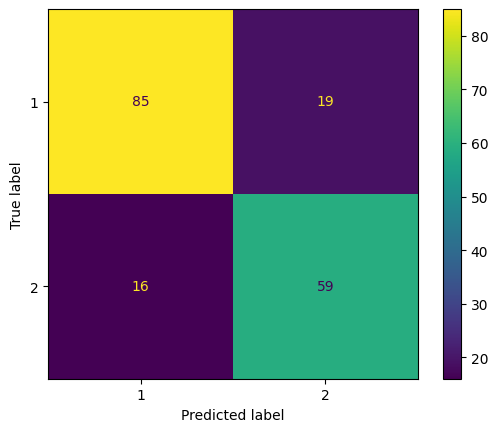

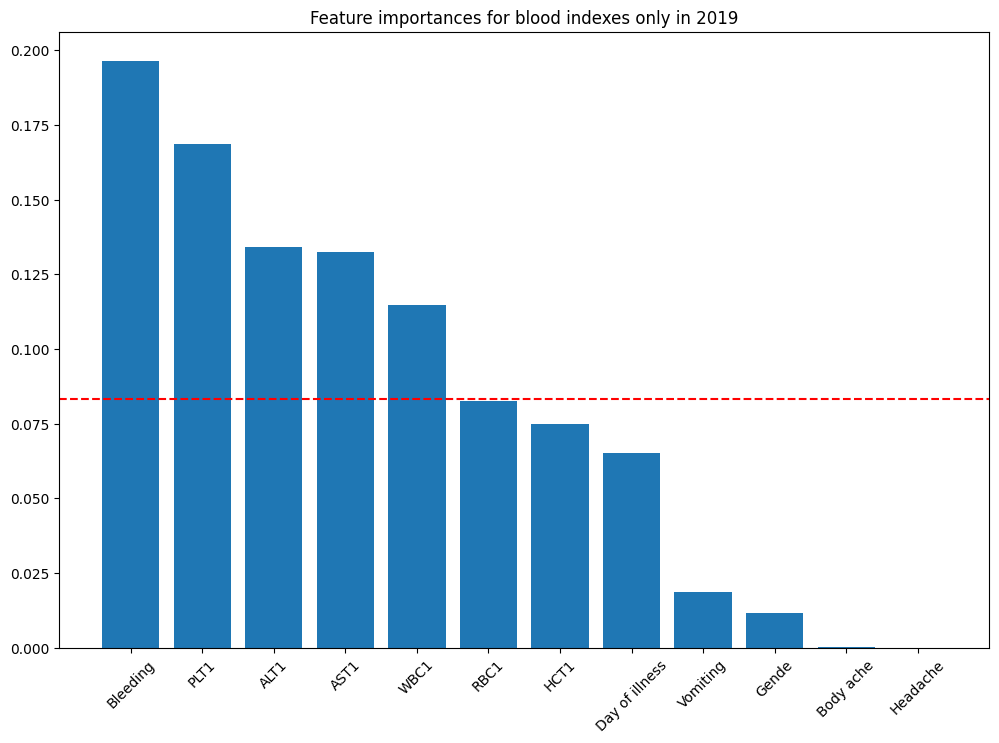

In [463]:
RF_model = RandomForestClassifier(random_state=22, max_depth=37, max_features='sqrt', min_samples_leaf=3, min_samples_split=7, n_estimators=323)
RF_model.fit(x_train, y_train)

y_pred = RF_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# features = XA_train.columns

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
_ = ConfusionMatrixDisplay.from_estimator(RF_model, x_test, y_test)

uniques, counts = np.unique(y_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y_pred), 2))))

# Plotting feature importances
importances = RF_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances for blood indexes only in 2019")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), features[indices], rotation=45)
plt.xlim([-1, x_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

In [263]:
def analyze_confusion_matrix(y_true, y_pred, class_names=None, title=None):
    """
    Analyze confusion matrix and calculate detailed metrics
    """
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate per-class metrics
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    # Set class names
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(cm))]
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=class_names, yticklabels=class_names)
    ax1.set_title(f'Confusion Matrix\nOverall Accuracy: {accuracy:.3f}')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # 2. Precision by Class
    bars1 = ax2.bar(class_names, precision, color='purple', alpha=0.7)
    ax2.set_title('Precision by Class')
    ax2.set_ylabel('Precision')
    ax2.set_ylim(0, 1)
    # Add value labels on bars
    for bar, val in zip(bars1, precision):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom')
    
    # 3. Recall by Class
    bars2 = ax3.bar(class_names, recall, color='lightgreen', alpha=0.7)
    ax3.set_title('Recall by Class')
    ax3.set_ylabel('Recall')
    ax3.set_ylim(0, 1)
    # Add value labels on bars
    for bar, val in zip(bars2, recall):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom')
    
    # 4. F1-Score by Class
    bars3 = ax4.bar(class_names, f1, color='turquoise', alpha=0.7)
    ax4.set_title('F1-Score by Class')
    ax4.set_ylabel('F1-Score')
    ax4.set_ylim(0, 1)
    # Add value labels on bars
    for bar, val in zip(bars3, f1):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom')
        
    fig.suptitle(title if title else 'Confusion Matrix Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("=" * 50)
    print("RANDOM FOREST CONFUSION MATRIX ANALYSIS")
    print("=" * 50)
    
    print(f"\nOverall Accuracy: {accuracy:.4f}")
    print(f"Number of test samples: {len(y_true)}")
    
    print("\nConfusion Matrix:")
    print(cm)
    
    print("\nPer-Class Metrics:")
    print("-" * 30)
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall:    {recall[i]:.4f}")
        print(f"  F1-Score:  {f1[i]:.4f}")
    
    print("\nMacro Averages:")
    print(f"  Precision: {np.mean(precision):.4f}")
    print(f"  Recall:    {np.mean(recall):.4f}")
    print(f"  F1-Score:  {np.mean(f1):.4f}")
    
    return cm, {'accuracy': accuracy, 'precision': precision, 
                'recall': recall, 'f1': f1}



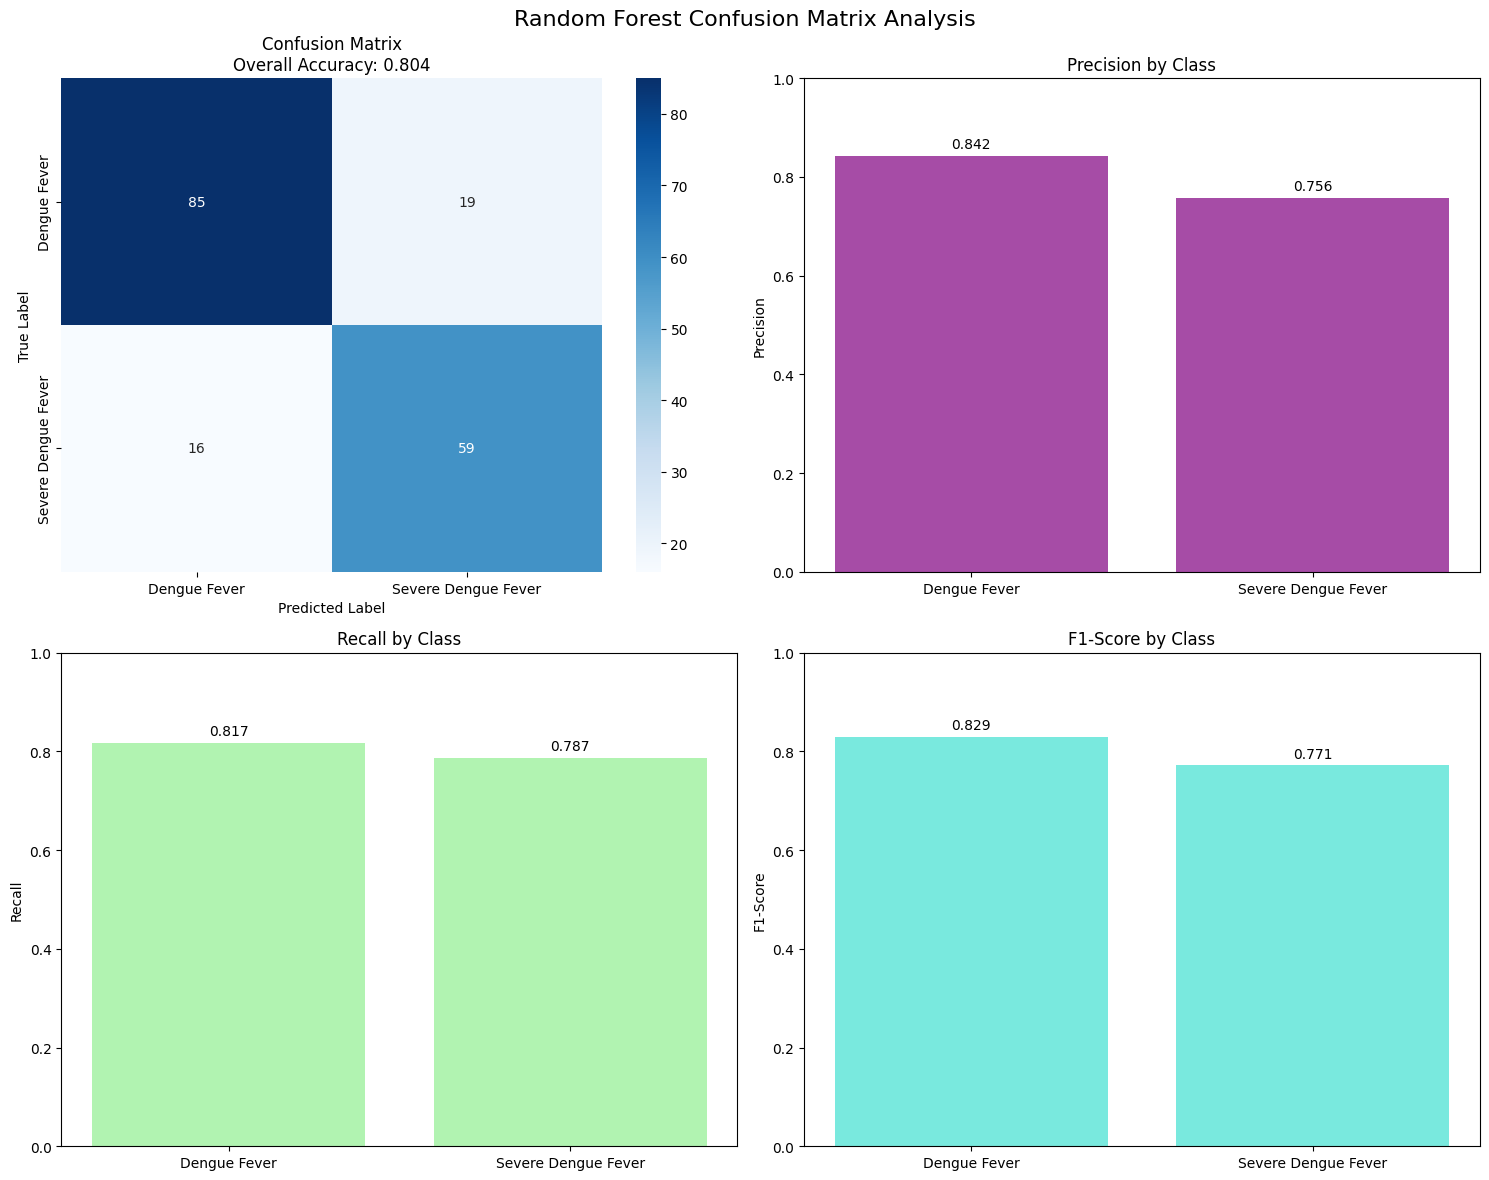

RANDOM FOREST CONFUSION MATRIX ANALYSIS

Overall Accuracy: 0.8045
Number of test samples: 179

Confusion Matrix:
[[85 19]
 [16 59]]

Per-Class Metrics:
------------------------------
Dengue Fever:
  Precision: 0.8416
  Recall:    0.8173
  F1-Score:  0.8293
Severe Dengue Fever:
  Precision: 0.7564
  Recall:    0.7867
  F1-Score:  0.7712

Macro Averages:
  Precision: 0.7990
  Recall:    0.8020
  F1-Score:  0.8003


In [264]:
# Analyze the confusion matrix
cm, metrics = analyze_confusion_matrix(y_test, y_pred, class_names=['Dengue Fever', 'Severe Dengue Fever'], title='Random Forest Confusion Matrix Analysis')

In [364]:
len(x_test[:,1])

179

In [377]:
rf_proba = RF_model.predict_proba(x_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, rf_proba))

ROC AUC Score: 0.8492307692307692


In [265]:
print(y_pred, y_test)

[1 2 2 2 2 2 2 1 1 2 2 2 1 1 2 1 1 2 1 1 1 2 2 1 2 1 1 2 2 1 1 1 2 1 1 2 1
 1 2 1 1 1 1 2 1 2 1 2 1 2 1 1 1 2 2 2 2 1 1 2 2 1 1 1 2 1 2 2 1 1 1 2 1 2
 1 2 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 1 1 2 2 2 1 2 1 1 2 2
 2 1 1 2 2 1 1 2 1 2 2 1 1 2 1 1 1 1 2 1 2 2 1 1 1 1 2 2 1 1 2 2 1 1 1 1 2
 1 1 2 2 1 2 2 1 2 2 1 1 1 2 1 1 2 1 2 2 1 1 2 2 1 2 1 1 1 2 2] [1 1 2 2 2 2 2 1 1 2 2 1 1 1 1 1 2 2 1 1 1 2 2 2 2 1 1 2 2 1 1 1 2 1 1 2 1
 1 2 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 2 1 1 2 1 2 2 2 1 1 1 2 2 2 1 1 1 2 1 2
 1 2 1 2 2 1 2 2 1 2 1 1 1 1 2 2 1 1 1 1 2 1 2 1 1 2 1 1 1 1 2 1 2 1 1 2 2
 2 1 1 1 2 1 1 2 1 2 2 1 1 2 2 2 1 1 2 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 2 2
 1 1 2 2 2 2 2 1 2 2 1 1 1 2 1 1 2 1 1 2 1 1 2 2 1 1 1 2 1 2 2]


In [400]:
boruta = BorutaPy(
   estimator = RF_model, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(Y))
features_arr = np.array(features)
red_area = features_arr[boruta.support_]
pink_area = features_arr[boruta.support_weak_]
print('features in the red area:', red_area)
print('features in the pink area:', pink_area)

features in the red area: ['AST' 'ALT' 'RBC' 'WBC' 'PLT' 'Bleeding']
features in the pink area: []


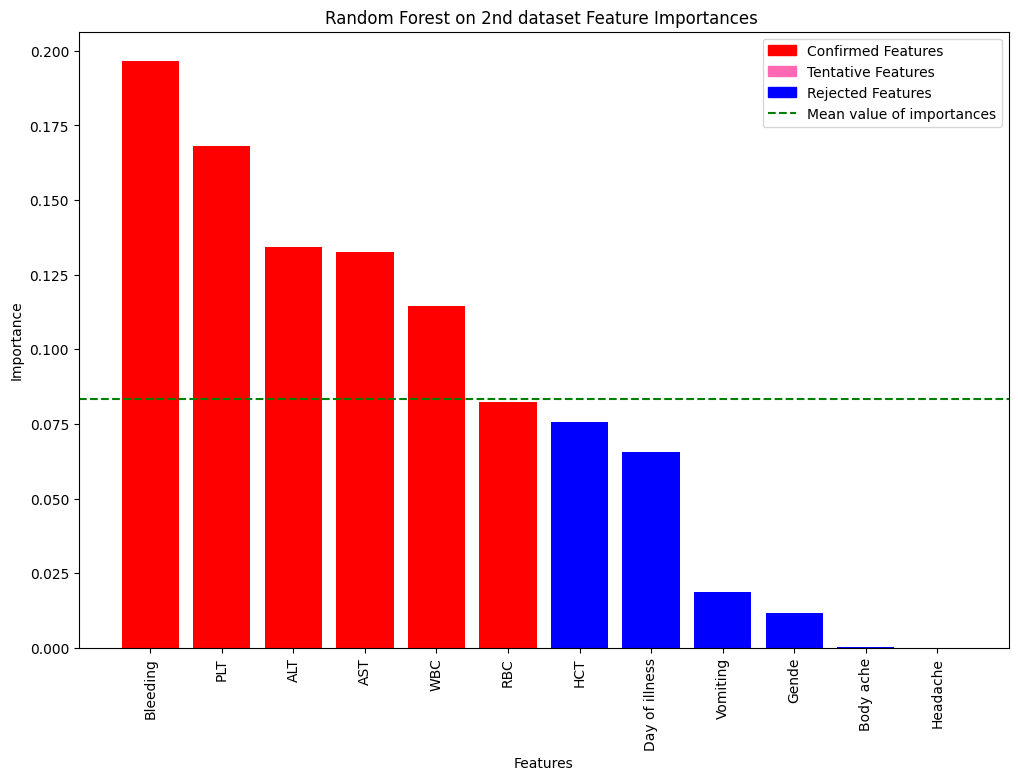

In [411]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

colors = np.asarray(['red' if cat in red_area else 'hotpink' if cat in pink_area else 'blue' for cat in features_arr])
# features_arr = np.array(features)
# red_patch = mpatches.Patch(color='red', label='Type 1')
# blue_patch = mpatches.Patch(color='blue', label='Type 2')
# green_patch = mpatches.Patch(color='green', label='Type 3')

plt.figure(figsize=(12, 8))
plt.title("Random Forest on 2nd dataset Feature Importances ")
plt.bar(range(x_train.shape[1]), importances[indices], align="center", color=colors[indices])
plt.xticks(range(x_train.shape[1]), list(features_arr[indices]), rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.axhline(y=importances.mean(), color='g', linestyle='--')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.legend(handles=[mpatches.Patch(color='red', label='Confirmed Features'), mpatches.Patch(color='hotpink', label='Tentative Features'), mpatches.Patch(color='blue', label='Rejected Features'), \
                    Line2D([0], [0], color='green', linestyle='--', label='Mean value of importances')], loc='upper right')
plt.show()

In [444]:
features

['Gende',
 'Day of illness',
 'AST',
 'ALT',
 'RBC',
 'WBC',
 'PLT',
 'HCT',
 'Bleeding',
 'Vomiting',
 'Headache',
 'Body ache']

Split values for PLT1: [np.float64(2.399999976158142), np.float64(2.399999976158142), np.float64(2.399999976158142), np.float64(2.399999976158142), np.float64(2.399999976158142), np.float64(2.399999976158142), np.float64(3.299999952316284), np.float64(3.299999952316284), np.float64(3.299999952316284), np.float64(3.299999952316284)]...
Total number of splits: 2082


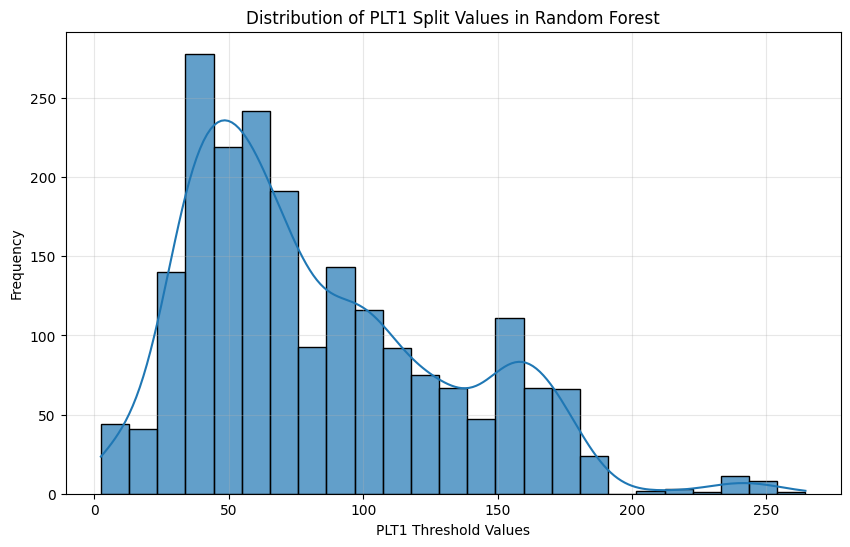

In [467]:
def extract_feature_split_values(forest, feature_names, target_feature):
    """
    Extract split values for a specific feature from a Random Forest model
    
    Args:
        forest: Trained RandomForestClassifier
        feature_names: List of feature names
        target_feature: Name of the feature to extract split values for
    
    Returns:
        List of split values for the target feature
    """
    if target_feature not in feature_names:
        raise ValueError(f"Feature '{target_feature}' not found in feature names")
    
    target_feature_idx = list(feature_names).index(target_feature)
    split_values = []
    
    # Loop through all trees in the forest
    for tree in forest.estimators_:
        tree_struct = tree.tree_
        feature = tree_struct.feature
        threshold = tree_struct.threshold
        
        # Loop through nodes in this tree
        for node_id in range(tree_struct.node_count):
            # Check if it's not a leaf node
            if tree_struct.children_left[node_id] != tree_struct.children_right[node_id]:
                # Check if this node splits on our target feature
                if feature[node_id] == target_feature_idx:
                    split_values.append(threshold[node_id])
    
    return sorted(split_values)

# Example usage - extract split values for PLT feature
plt_splits = extract_feature_split_values(RF_model, features, 'PLT1')
print(f"Split values for PLT1: {plt_splits[:10]}...")  # Show first 10
print(f"Total number of splits: {len(plt_splits)}")

# Plot histogram of split values for PLT1
plt.figure(figsize=(10, 6))
sns.histplot(plt_splits,kde=True, alpha=0.7, edgecolor='black')
plt.title('Distribution of PLT1 Split Values in Random Forest')
plt.xlabel('PLT1 Threshold Values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

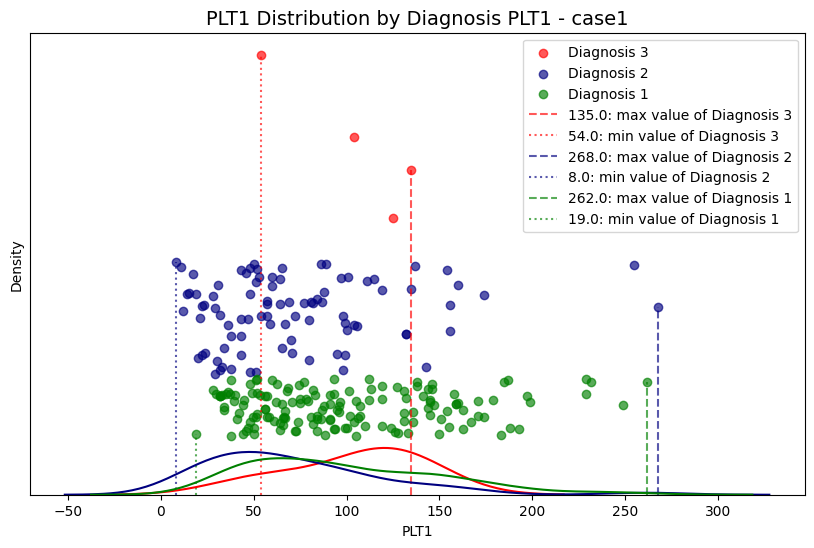

In [477]:
distribution_plot(df_case1, x_name='PLT1', data_name='PLT1 - case1')

In [478]:
df_case1['PLT1'].describe()

count    595.000000
mean      97.587882
std       60.348596
min        1.300000
25%       50.000000
50%       87.000000
75%      137.000000
max      290.000000
Name: PLT1, dtype: float64

### XGB

In [209]:
Y = Y - 1

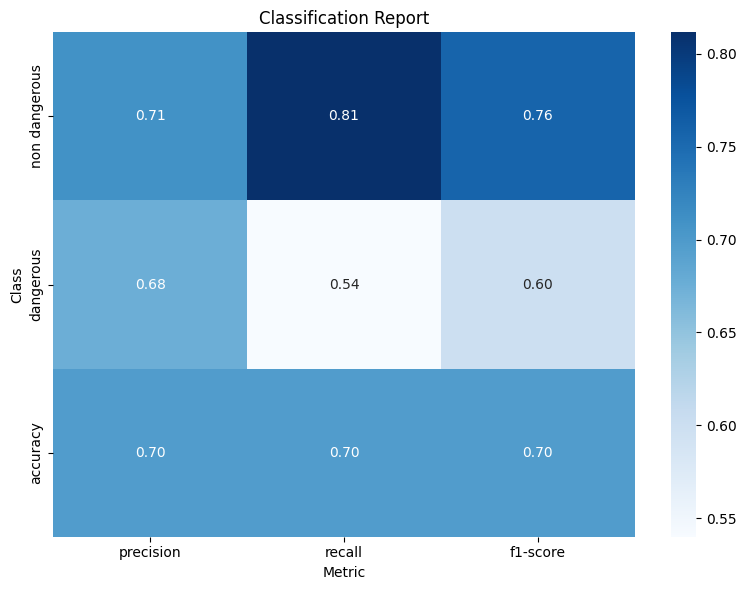

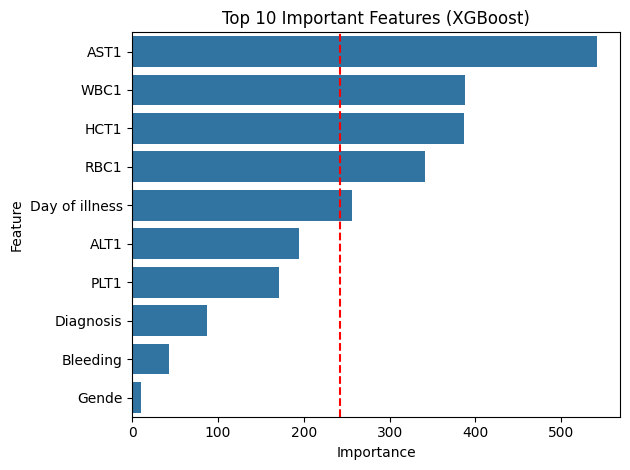

In [210]:

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17, stratify=Y)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    # use_label_encoder=False,
    eval_metric='error'
)

xgb_model.fit(x_train, y_train)
evaluate(xgb_model, x_test, y_test)
gain_importances_df = plot_feature_importance(xgb_model, features, importance_type='total_gain')

### LightGBM

In [118]:
import lightgbm as lgb

In [119]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5, -1],  # -1 means no limit
    'min_child_samples': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

random_search = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1), # type: ignore
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_weighted',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit random search
random_search.fit(x_train, y_train)

/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/v

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-1),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [2, 3, 4, 5, -1],
                                        'min_child_samples': [5, 10, 20, 50],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1_weighted')

In [120]:
# Get best parameters
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Train final model with best parameters
best_lgb_model = lgb.LGBMClassifier(**random_search.best_params_, random_state=42)
best_lgb_model.fit(x_train, y_train)

Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 50, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best Score: 0.7948162042043048


LGBMClassifier(colsample_bytree=0.8, min_child_samples=10, n_estimators=50,
               random_state=42, reg_alpha=1, reg_lambda=0.1)

### LSTM

In [21]:
df_case1

,Gende,Diagnosis,Day of illness,AST1,ALT1,RBC1,WBC1,PLT1,HCT1,Bleeding,Vomiting,Headache,Body ache
0,1,2,5,240.2,22.5,5.040,1.45,59.00,0.461,1,0,1,1
1,1,1,4,32.0,0.0,4.900,4.10,67.00,0.470,0,0,1,1
2,0,1,3,75.2,46.8,4.590,2.44,146.00,0.392,0,1,1,1
3,0,2,4,70.7,37.5,3.940,4.50,156.00,0.375,1,1,1,1
4,0,2,3,51.9,41.0,3.880,2.32,63.00,0.353,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,0,1,5,123.9,57.5,4.608,2.99,34.85,0.400,0,0.0,1,1
591,1,1,2,22.6,14.6,4.300,3.65,138.00,0.382,0,0.0,1,1
592,0,1,5,77.5,59.9,3.390,3.08,141.00,0.293,0,0.0,1,1
593,0,1,6,129.8,75.9,4.430,2.90,61.00,0.365,0,0.0,1,1


In [ ]:
df_case1.fillna(0, inplace=True)

In [63]:
Y = df_case1['Diagnosis'].copy().to_numpy().astype(float)
Y = Y -1

X = df_case1.drop(columns=['Diagnosis']).copy().to_numpy().astype(float)

In [77]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=15, stratify=Y)

print('x_train shape: ', x_train.shape, 'y_train shape: ',  y_train.shape)
print('x_test shape: ', x_test.shape, 'y_test shape: ',  y_test.shape)
uniques, counts = np.unique(y_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y_test), 2))))

uniques, counts = np.unique(y_train, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y_train), 2))))

x_train shape:  (505, 12) y_train shape:  (505,)
x_test shape:  (90, 12) y_test shape:  (90,)
percentage of classes:  {np.float64(0.0): np.float64(57.78), np.float64(1.0): np.float64(42.22)}
percentage of classes:  {np.float64(0.0): np.float64(58.42), np.float64(1.0): np.float64(41.58)}


In [18]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model # type: ignore
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, SpatialDropout1D, Layer, BatchNormalization # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
import tensorflow.keras.backend as K # type: ignore

2025-06-19 04:06:11.443613: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-19 04:06:11.447017: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-19 04:06:11.457236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750298771.475384  175906 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750298771.480546  175906 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750298771.495415  175906 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [34]:
def prepare_data_for_lstm(X, y):
    """Prepare data for LSTM model with attention"""
    # Scale features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert target to binary format
    # y_binary = (y == '2').astype(int)  # Assuming class '2' is the positive class
    
    # Reshape input to 3D format expected by LSTM: [samples, timesteps, features]
    # For this model, we use the entire feature vector as a single timestep sequence
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    
    return X_reshaped, y, scaler


In [78]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # Remove dimension of size 1. [batch_size, seq_len]
        e = K.squeeze(e, axis=-1)
        
        # Compute the weights. [batch_size, seq_len]
        alpha = K.softmax(e)
        
        # Reshape to [batch_size, seq_len, 1]
        alpha = K.expand_dims(alpha, axis=-1)
        
        # Compute the context vector. [batch_size, features]
        context = x * alpha
        context = K.sum(context, axis=1)
        
        return context 
    
class middleAttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(middleAttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(middleAttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # # Remove dimension of size 1. [batch_size, seq_len]
        # e = K.squeeze(e, axis=-1)

        # # Compute the weights. [batch_size, seq_len]
        # alpha = K.softmax(e)
        
        # # Reshape to [batch_size, seq_len, 1]
        # alpha = K.expand_dims(alpha, axis=-1)
        
        self.attention_weights = K.softmax(e, axis=-1)

        # Compute the context vector. [batch_size, features]
        context = x * self.attention_weights
   
        return context  

def create_lstm_with_attention(input_shape, dropout_rate=0.2):
    """
    Create an LSTM model with Spatial Dropout and Attention for binary classification
    
    Args:
        input_shape: Tuple (timesteps, features) specifying input dimensions
        dropout_rate: Dropout rate to prevent overfitting
    
    Returns:
        Compiled Keras LSTM model with attention
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Spatial Dropout layer
    # This helps with overfitting by dropping entire feature maps
    x = BatchNormalization()(inputs)
    # print("x shape after BatchNormalization:", x.shape)  # Debugging line to check input shape
    # LSTM layer
    x = LSTM(12, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    
    # Attention layer
    x = middleAttentionLayer()(x)

    x = LSTM(12, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    x = AttentionLayer()(x)

    # Dropout for regularization
    x = Dropout(dropout_rate)(x)
 
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x) 
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), 
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()]
    )
    
    return model

In [105]:
# Assuming x1_train, y1_train, x1_test, y1_test are available from your notebook

# Prepare data 
# Option 1: Single timestep with all features
X_train_lstm, y_train_lstm, scaler = prepare_data_for_lstm(x_train, y_train)
# print("X_train_lstm shape:", X_train_lstm.shape)
X_test_lstm, y_test_lstm, _ = prepare_data_for_lstm(x_test, y_test)

# Option 2: Multiple timesteps (feature groups)
# X_train_lstm, y_train_lstm, scaler = prepare_sequence_data(x1_train, y1_train, n_steps=4)
# X_test_lstm, y_test_lstm, _ = prepare_sequence_data(x1_test, y1_test, n_steps=4)

# Create model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (timesteps, features)
print("Input shape for LSTM with attention:", input_shape)
model = create_lstm_with_attention(input_shape,dropout_rate=0)

# Model summary
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    # ModelCheckpoint('best_lstm_attention_model.h5', save_best_only=True, monitor='val_loss'),
    # Optionally add learning rate reduction callback
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=0.001
    )
]

# Calculate class weights - important for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(y_train_lstm)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_lstm)
class_weight_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class weights:", class_weight_dict)

# Train model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=150,
    batch_size=32,
    validation_split=0.15,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)



Input shape for LSTM with attention: (1, 12)


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 1, 12)          │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 1, 12)          │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_55            │ (None, 1, 12)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ middle_attention_layer_25       │ (None, 1, 12)          │            13 │
│ (middleAttentionLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 1, 12)          │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_56            │ (None, 1, 12)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_29              │ (None, 12)             │            13 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,487 (9.71 KB)

 Trainable params: 2,463 (9.62 KB)

 Non-trainable params: 24 (96.00 B)

Class weights: {np.float64(0.0): np.float64(0.8559322033898306), np.float64(1.0): np.float64(1.2023809523809523)}
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.3926 - auc_29: 0.3819 - loss: 0.7036 - precision_29: 0.3505 - recall_29: 0.4290 - val_accuracy: 0.2368 - val_auc_29: 0.3949 - val_loss: 0.6966 - val_precision_29: 0.2615 - val_recall_29: 0.6296 - learning_rate: 0.0010
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5010 - auc_29: 0.5521 - loss: 0.6929 - precision_29: 0.4351 - recall_29: 0.6587 - val_accuracy: 0.3684 - val_auc_29: 0.5563 - val_loss: 0.6939 - val_precision_29: 0.3478 - val_recall_29: 0.8889 - learning_rate: 0.0010
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5534 - auc_29: 0.6378 - loss: 0.6906 - precision_29: 0.4773 - recall_29: 0.7385 - val_accuracy: 0.6711 - val_auc_29: 0.7041 - val_loss: 0.6903 - val_precision_29: 0.5238 - val_recall_29: 0.8148 - learning_rate: 0.0010
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7104 - auc_27: 0.8009 - loss: 0.5581 - precision_27: 0.6466 - recall_27: 0.7369
Test loss: 0.5477
Test accuracy: 0.7333
Test AUC: 0.8057
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

LSTM with Attention Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76        52
         1.0       0.67      0.74      0.70        38

    accuracy                           0.73        90
   macro avg       0.73      0.73      0.73        90
weighted avg       0.74      0.73      0.73        90



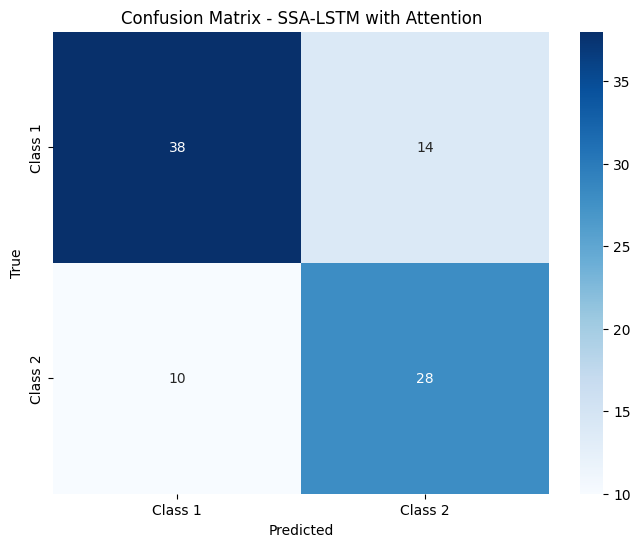

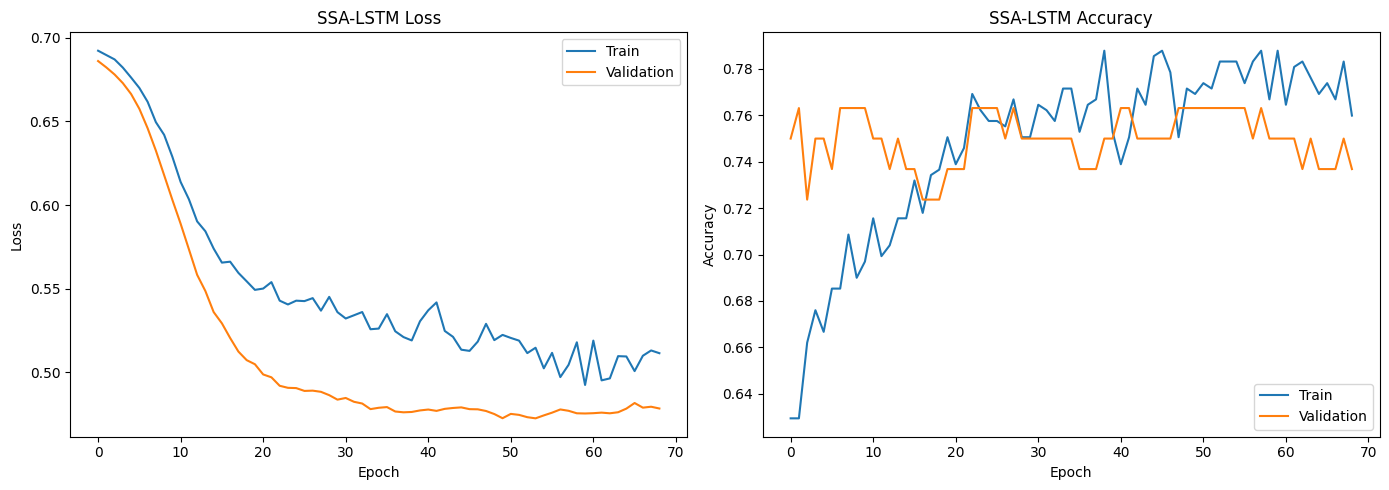

In [103]:
# Evaluate on test set
test_results = model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"Test loss: {test_results[0]:.4f}")
print(f"Test accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
# Make predictions
y_pred_proba = model.predict(X_test_lstm, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Flatten to ensure compatible shape
# Make predictions
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nLSTM with Attention Classification Report:")
print(classification_report(y_test_lstm, y_pred))



# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_lstm, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 1', 'Class 2'],
            yticklabels=['Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SSA-LSTM with Attention')
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('SSA-LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('SSA-LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [87]:
y_pred

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0])

In [84]:
y_test_lstm

array([0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 1., 0., 1., 0.])

### ExtraTrees

In [211]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(x_train, y_train)
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.7647058823529411
Confusion Matrix:
 [[59 10]
 [18 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81        69
           1       0.76      0.64      0.70        50

    accuracy                           0.76       119
   macro avg       0.76      0.75      0.75       119
weighted avg       0.76      0.76      0.76       119



# Case 2: all the datasets

In [148]:
df_2025['Diagnosis'] = df_2025['Chẩn đoán '].str.contains('DHCB|dấu hiệu cảnh báo').astype(int) + 1

In [149]:
df_2025.drop(['STT','Số bệnh án','Họ & tên','Chẩn đoán ','Năm sinh','Tuổi','Cân nặng','Chiều cao','BMI',\
              'Mạch','THA','HATT','HATTr','NEU','%NEU','LYM','%LYM','HGB','URE','CRE','BILI-TP','BILI-TT',\
                'ALBUMUN','Glucose','MaBenhpham','IgG','IgM','KN B19','NestedPCR'], inplace=True, axis=1)


In [ ]:
df_case2 = df_case1.drop(['Bleeding', 'Vomiting', 'Headache', 'Body ache', 'Day of illness'], axis=1).copy()
# df_case2
df_2025 = df_2025.rename(columns={
    'Giới tính': 'Gende',
    'AST': 'AST1',
    'ALT': 'ALT1',
    'RBC': 'RBC1',
    'WBC': 'WBC1',
    'PLT': 'PLT1',
    'HCT': 'HCT1'
})

df_case2 = pd.concat([df_case2, df_2025], axis=0, ignore_index=True)
df_case2['Diagnosis'] = np.where(df_case2['Diagnosis'] == '3', '2', df_case2['Diagnosis'])
df_case2['Diagnosis'] = np.where(df_case2['Diagnosis'] == 3, '2', df_case2['Diagnosis'])

### RF

In [187]:
diag_symptoms = df_case2['Diagnosis']
df_case2.drop(columns=['Diagnosis'], inplace=True)
features = df_case2.columns

X = df_case2.values
Y = diag_symptoms.values.ravel()

X = X.astype(float)
Y = Y.astype(int)
print(X.dtype)
print(Y.dtype)

uniques, counts = np.unique(Y, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(Y), 2))))

float64
int64
percentage of classes:  {np.int64(1): np.float64(58.61), np.int64(2): np.float64(41.39)}


In [195]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

rf_model = RandomForestClassifier()

accuracies = []

# Stratified K-Fold loop
for train_index, val_index in skf.split(X, Y):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    rf_model.fit(X_train, Y_train)
    preds = rf_model.predict(X_val)
    acc = accuracy_score(Y_val, preds)
    accuracies.append(acc)

print(f"Cross-validated accuracy scores: {accuracies}")
print(f"Mean accuracy: {np.mean(accuracies):.4f}")

Cross-validated accuracy scores: [0.7361111111111112, 0.625, 0.7638888888888888, 0.75, 0.6666666666666666, 0.6944444444444444, 0.625, 0.7083333333333334, 0.7083333333333334, 0.7222222222222222]
Mean accuracy: 0.7000


In [200]:
param_grid = {'n_estimators': [50, 75, 100, 200], 'max_depth': [3, 7, 9, 15], 'min_samples_split': [2, 5, 10, 12 ], 'min_samples_leaf': [1, 2, 4,6,8], 'max_features': ['sqrt', 'log2']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
grid.fit(X, Y)

print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.7027777777777777


### XGB 

In [196]:
Y = Y - 1

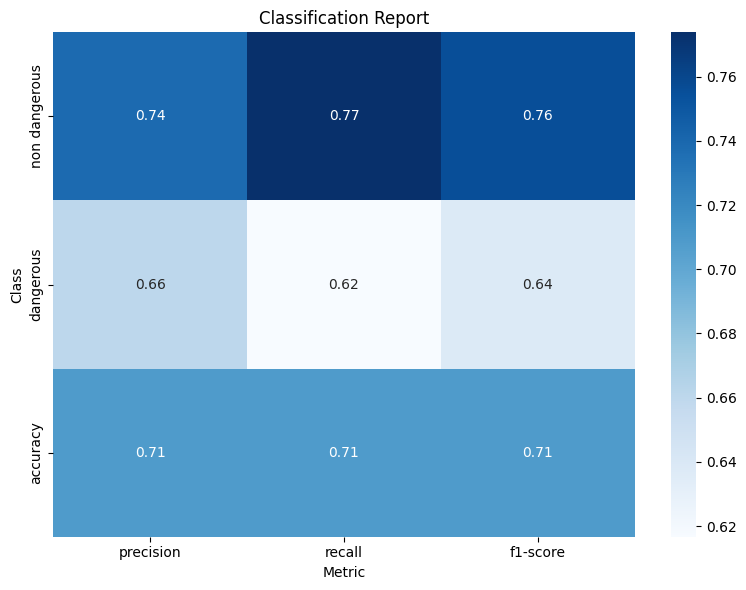

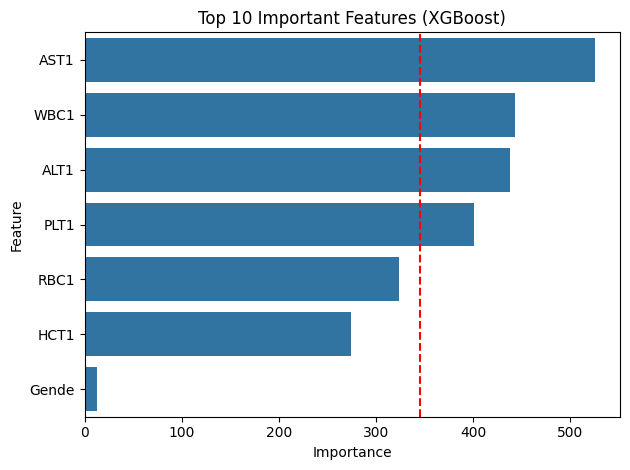

In [197]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17, stratify=Y)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    # use_label_encoder=False,
    eval_metric='error'
)

xgb_model.fit(x_train, y_train)
evaluate(xgb_model, x_test, y_test)
gain_importances_df = plot_feature_importance(xgb_model, features, importance_type='total_gain')

### LightGBM

In [135]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5, -1],  # -1 means no limit
    'min_child_samples': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

random_search = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1), # type: ignore
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_weighted',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit random search
random_search.fit(x_train, y_train)

NameError: name 'lgb' is not defined

In [199]:
# Get best parameters
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Train final model with best parameters
best_lgb_model = lgb.LGBMClassifier(**random_search.best_params_, random_state=42)
best_lgb_model.fit(x_train, y_train)

Best Parameters: {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best Score: 0.6825581345808319


LGBMClassifier(colsample_bytree=0.6, max_depth=3, min_child_samples=5,
               random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=0.6)

### ExtraTreess

In [204]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(x_train, y_train)
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 500}
Accuracy: 0.6319444444444444
Confusion Matrix:
 [[61 23]
 [30 30]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70        84
           1       0.57      0.50      0.53        60

    accuracy                           0.63       144
   macro avg       0.62      0.61      0.61       144
weighted avg       0.63      0.63      0.63       144



# Case 3: only 2017/2019

## data loader

In [493]:
df

,Diagnosis,Gende,DHF infection His.,additional_diseases,Fever,Bleeding,Fatigue,Day of illness,Level of temp,Duration fever,...,Unnamed: 511,Unnamed: 512,Unnamed: 513,Unnamed: 514,Unnamed: 515,Unnamed: 516,Unnamed: 517,Unnamed: 518,Unnamed: 519,Unnamed: 520
0,2,1,0,1,1,0,0,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0,1,1,0,0,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,0,0,1,0,0,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,1,0,1,1,1,0,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,0,1,1,0,1,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,2,0,0,1,1,1,1,4,2,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,2,0,0,1,1,0,1,5,3,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,1,1,0,0,1,0,1,6,3,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,2,1,0,1,1,0,1,7,3,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [503]:
df_set = df.loc[:, 'Diagnosis':'Oliguria'].copy().fillna(0) #'Gende'
df_set.apply(pd.to_numeric, errors='coerce')

Y = df['Diagnosis'].copy().to_numpy().astype(float)
Y = Y -1

symptoms_features = df_set.columns.to_list()


In [504]:
df_bl = df.loc[:, 'WBC1':'MPV 9'].copy()
# df_bl = df_bl.apply(pd.to_numeric, errors='coerce')


df_bl = df_bl.drop(['MPV 1','MPV 2','MPV 3','MPV 4', 'MPV 5', 'MPV 6', 'MPV 7', 'MPV 8', 'MPV 9'], axis=1)
df_bl = df_bl.replace('(17/9)3.7', 3.7)
df_bl = df_bl.replace('(28/6)4.1', 4.1)
df_bl = df_bl.replace('(27/11)5.5', 5.5)
df_bl = df_bl.replace(' ', np.nan)
blood_features = df_bl.columns
for i in df_bl.columns:
    df_bl[i] = df_bl[i].str.replace(',', '.', regex=False).astype(float)
df_bl.reset_index(drop=True, inplace=True) #reset index
df_bl.fillna(0, inplace=True) #fill NaN with 0
df_bl = df_bl.to_numpy()

print(df_bl.shape)

bl_list = []
bl_arr = []
for i in range(df_bl.shape[0]):
    # Extract non-zero elements
    non_zero_elements = df_bl[i][np.nonzero(df_bl[i])]
    bl_list.append(non_zero_elements)
    bl_arr.append(bl_list[i][:7])


bl_arr = np.array(bl_arr)
print(bl_arr.shape)

# print(len(bl_arr))
blood_features = blood_features[:7].tolist()
print(blood_features)
for i in range(len(blood_features)):
    blood_features[i] = blood_features[i][:-1]

print(blood_features)

(406, 63)
(406, 7)
['WBC1', 'N1', 'L1', 'RBC1', 'Hb1', 'HCT1', 'PLT1']
['WBC', 'N', 'L', 'RBC', 'Hb', 'HCT', 'PLT']


In [505]:
df_alt = df.loc[:, 'Glu1':'GGT9'].copy()
# df_bl = df_bl.apply(pd.to_numeric, errors='coerce')


df_alt = df_alt.drop(['Bil TP7','Bil TT 7'], axis=1)
df_alt = df_alt.replace('(18/6)7.2', 7.2)
df_alt = df_alt.replace("(8/6)9", 9)
df_alt = df_alt.replace("(4/12)", np.nan)
df_alt = df_alt.replace("(11/7)", np.nan)
df_alt = df_alt.replace('(', np.nan)
df_alt = df_alt.replace(' ', np.nan)
alt_features = df_alt.columns
for i in df_alt.columns:
    df_alt[i] = df_alt[i].str.replace(',', '.', regex=False).astype(float)
df_alt.reset_index(drop=True, inplace=True) #reset index
df_alt.fillna(0, inplace=True) #fill NaN with 0
df_alt = df_alt.to_numpy()

print(df_alt.shape)

print(len(bl_arr))
alt_features = alt_features[:7].tolist()
print(alt_features)
for i in range(len(alt_features)):
    alt_features[i] = alt_features[i][:-1]

print(alt_features)

alt_arr = process_alt_column_array(df_alt)
print(len(alt_arr))
alt_arr = np.array(alt_arr)

(406, 63)
406
['Glu1', 'Ure1', 'Cre1', 'Alb1', 'AST1', 'ALT1', 'GGT1']
['Glu', 'Ure', 'Cre', 'Alb', 'AST', 'ALT', 'GGT']
406


In [506]:
zero_indices = np.where((alt_arr[:, 4] == 0) | (alt_arr[:, 5] == 0))[0]
zero_indices

array([  0,   1,   2,  20,  25,  31,  34,  44,  45,  47,  60,  61,  64,
        67,  70,  84,  87,  88,  89,  93,  96, 103, 109, 132, 133, 138,
       139, 142, 162, 191, 200, 201, 202, 204, 220, 231, 240, 248, 258,
       262, 267, 269, 270, 273, 296, 299, 309, 319, 325, 330, 341, 351,
       356, 374, 382, 397])

In [507]:
bl_arr = np.delete(bl_arr, zero_indices, axis=0)
alt_arr = np.delete(alt_arr, zero_indices, axis=0)
symptoms_arr = np.delete(df_set.to_numpy().astype(float), zero_indices, axis=0)
Y = np.delete(Y, zero_indices, axis=0)

print(symptoms_arr.shape, bl_arr.shape, alt_arr.shape,Y.shape)


(350, 25) (350, 7) (350, 7) (350,)


In [508]:
X = np.hstack((symptoms_arr, bl_arr, alt_arr))
# X = np.hstack((symptoms_arr, bl_arr))
features = symptoms_features + blood_features + alt_features

In [328]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=15, stratify=Y)

print('x_train shape: ', x_train.shape, 'y_train shape: ',  y_train.shape)
print('x_test shape: ', x_test.shape, 'y_test shape: ',  y_test.shape)
uniques, counts = np.unique(y_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y_test), 2))))

uniques, counts = np.unique(y_train, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y_train), 2))))

x_train shape:  (280, 38) y_train shape:  (280,)
x_test shape:  (70, 38) y_test shape:  (70,)
percentage of classes:  {np.float64(0.0): np.float64(57.14), np.float64(1.0): np.float64(42.86)}
percentage of classes:  {np.float64(0.0): np.float64(56.43), np.float64(1.0): np.float64(43.57)}


In [509]:
X.shape

(350, 39)

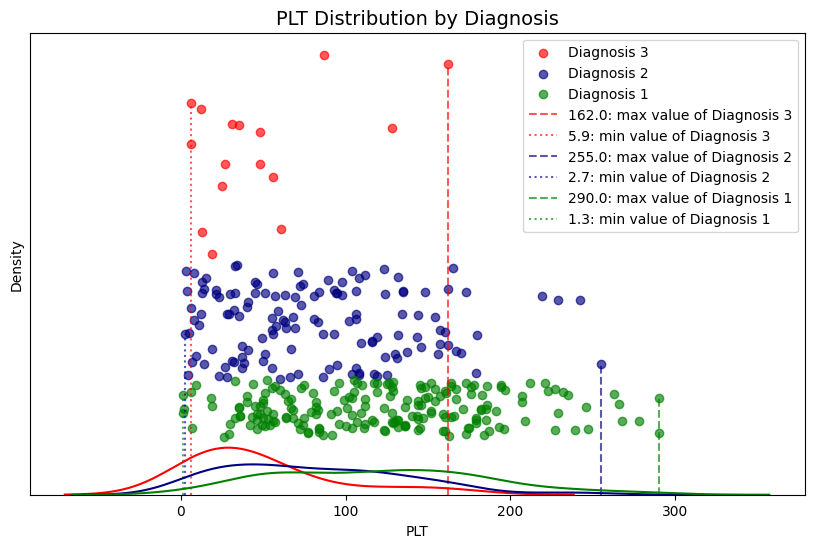

In [511]:
distribution_plot(pd.DataFrame(X, columns=features), x_name='PLT')

## RF

In [134]:
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 25),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}
scorer = make_scorer(roc_auc_score)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_distributions,
    n_iter=100,  # number of parameter settings sampled
    cv=10,
    scoring=scorer,
    n_jobs=-1,
    verbose=2,
    random_state=17
)

# Fit the random search
random_search.fit(x_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.1s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.1s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.2s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.2s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.2s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.2s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.2s
[CV] END max_depth=20, max_features=None, min_samples_leaf=17, min_samples_split=15, n_estimators=328; total time=   1.3s
[CV] END max_depth=20, m

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x76d9ef5deff0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x76d9ef5dd2e0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x76d9ef5dd400>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x76d9ef5dcef0>},
                   random_state=17,
                   scoring=make_scorer(roc_auc_score, response_method='predict'),
                   verbose=2)

In [170]:
random_search.best_params_

{'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 13,
 'n_estimators': 129}

Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83        40
         1.0       0.79      0.73      0.76        30

    accuracy                           0.80        70
   macro avg       0.80      0.79      0.79        70
weighted avg       0.80      0.80      0.80        70

percentage of predictions:  {np.float64(0.0): np.float64(60.0), np.float64(1.0): np.float64(40.0)}


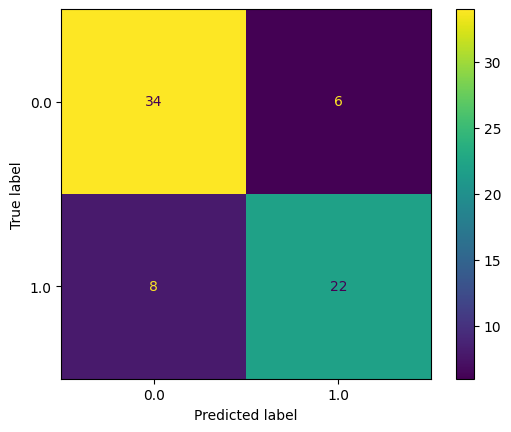

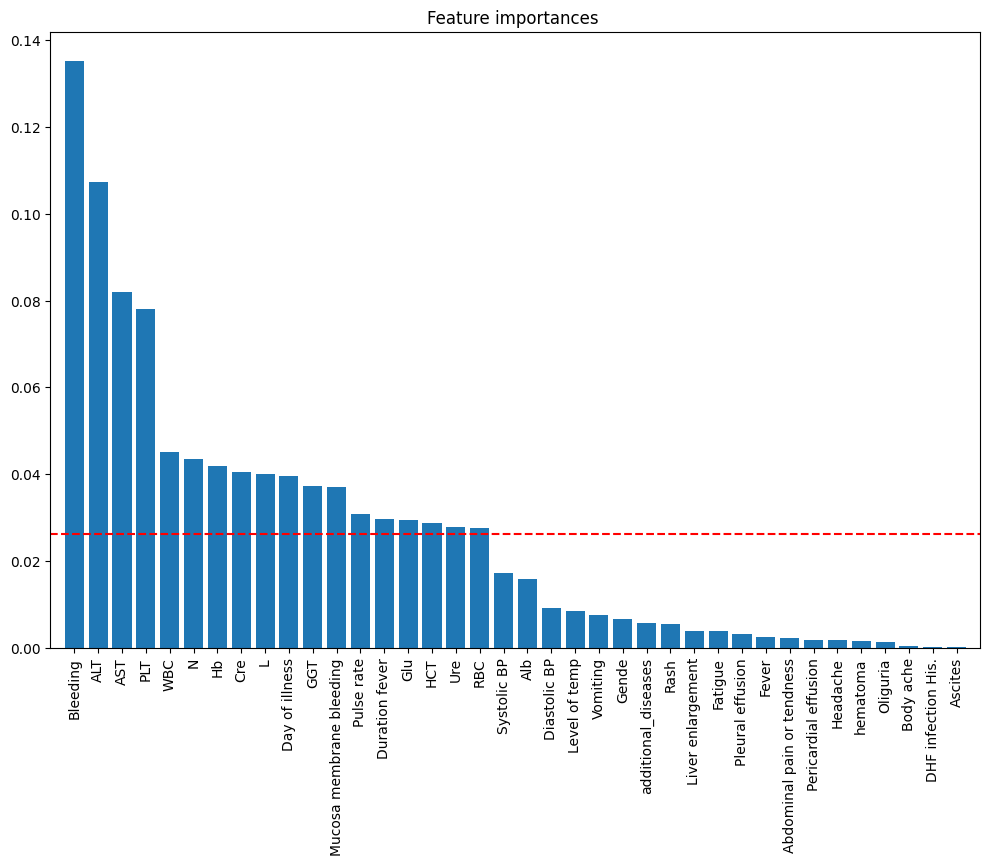

In [330]:
RF_model = RandomForestClassifier(random_state=22, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=13, n_estimators=129)
RF_model.fit(x_train, y_train)

y_pred = RF_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# features = XA_train.columns

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
_ = ConfusionMatrixDisplay.from_estimator(RF_model, x_test, y_test)

uniques, counts = np.unique(y_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y_pred), 2))))

# Plotting feature importances
importances = RF_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_arr = np.array(features)

plt.figure(figsize=(12, 8))
plt.title("Feature importances ")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), list(features_arr[indices]), rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

In [168]:
y_pred

array([0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0.])

In [169]:
y_test

array([0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0.])

In [174]:
from boruta import BorutaPy

boruta = BorutaPy(
   estimator = RF_model, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(Y))
### print results


BorutaPy(estimator=RandomForestClassifier(max_depth=10, min_samples_split=13,
                                          n_estimators=42,
                                          random_state=RandomState(MT19937) at 0x76DB34154140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x76DB34154140)

In [178]:
# features_arr = np.array(features)
# print("Boruta support:", boruta.support_)
red_area = features_arr[boruta.support_]
pink_area = features_arr[boruta.support_weak_]
print('features in the red area:', red_area)
print('features in the pink area:', pink_area)

features in the red area: ['Bleeding' 'WBC' 'N' 'PLT' 'AST' 'ALT' 'GGT']
features in the pink area: ['RBC']


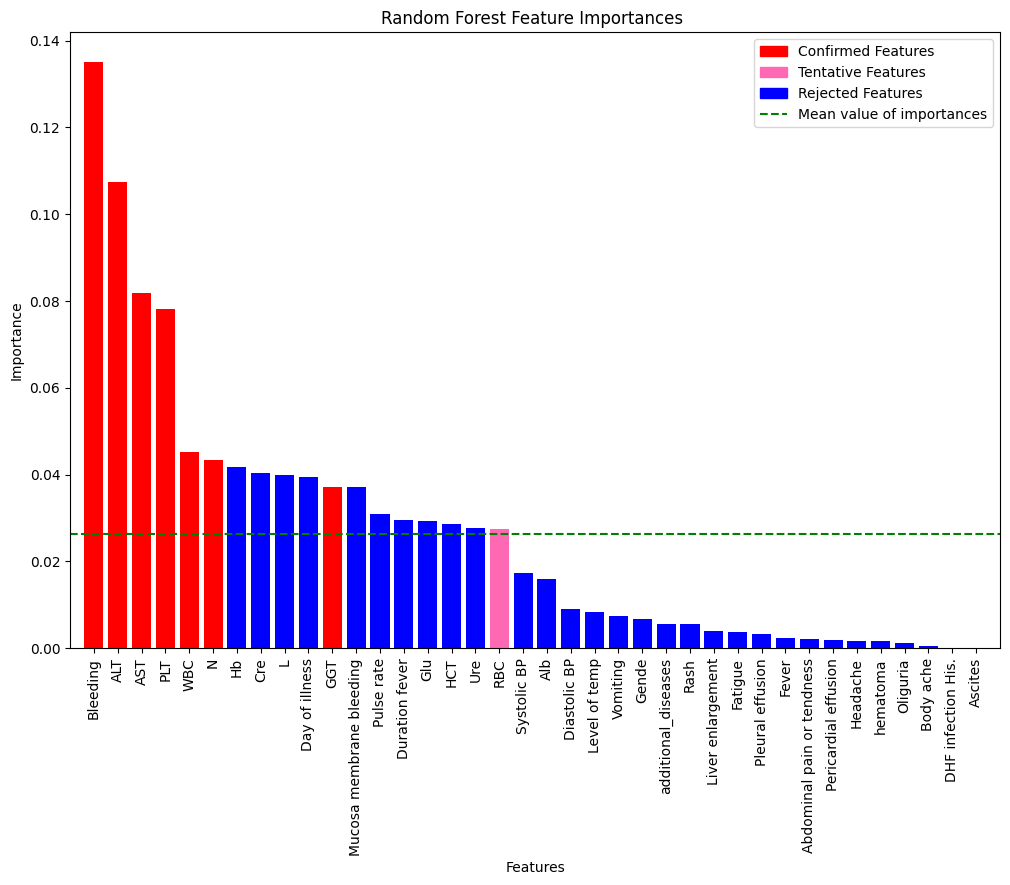

In [202]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

colors = np.asarray(['red' if cat in red_area else 'hotpink' if cat in pink_area else 'blue' for cat in features_arr])

# red_patch = mpatches.Patch(color='red', label='Type 1')
# blue_patch = mpatches.Patch(color='blue', label='Type 2')
# green_patch = mpatches.Patch(color='green', label='Type 3')

plt.figure(figsize=(12, 8))
plt.title("Random Forest Feature Importances ")
plt.bar(range(x_train.shape[1]), importances[indices], align="center", color=colors[indices])
plt.xticks(range(x_train.shape[1]), list(features_arr[indices]), rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.axhline(y=importances.mean(), color='g', linestyle='--')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.legend(handles=[mpatches.Patch(color='red', label='Confirmed Features'), mpatches.Patch(color='hotpink', label='Tentative Features'), mpatches.Patch(color='blue', label='Rejected Features'), \
                    Line2D([0], [0], color='green', linestyle='--', label='Mean value of importances')], loc='upper right')
plt.show()

In [331]:
rf_proba = RF_model.predict_proba(x_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, rf_proba))

ROC AUC Score: 0.8375


## XGB

In [194]:
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 50),
    # 'min_samples_split': randint(2, 25),
    # 'min_samples_leaf': randint(1, 20),
    # 'max_features': ['sqrt', 'log2', None],
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}
scorer = make_scorer(roc_auc_score)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(),
    param_distributions=param_distributions,
    n_iter=100,  # number of parameter settings sampled
    cv=10,
    scoring=scorer,
    n_jobs=-1,
    verbose=0,
    random_state=17
)

In [195]:
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrai...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x76d997fc2630>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x76d9761eb710>,
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [0, 0.01, 0.1, 1],
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=17,
                   scoring=make_scorer(roc_auc_score, response_method='predict'))

In [196]:
random_search.best_params_

{'colsample_bytree': np.float64(0.6),
 'gamma': 0.4,
 'learning_rate': np.float64(0.26999999999999996),
 'max_depth': 26,
 'n_estimators': 460,
 'reg_alpha': 0.01,
 'reg_lambda': 0.1,
 'subsample': np.float64(1.0)}

In [198]:
xgb_model = random_search.best_estimator_

In [333]:
xgb_model = xgb.XGBClassifier(
    n_estimators=460,
    learning_rate=0.269,
    max_depth=26,
    # use_label_encoder=False,
    colsample_bytree= np.float64(0.6),
    subsample= np.float64(1.0),
    reg_alpha=0.01,
    reg_lambda=0.1,
    gamma=0.4

)

xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.6), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.269, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=26, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=460, n_jobs=None,
              num_parallel_tree=None, ...)

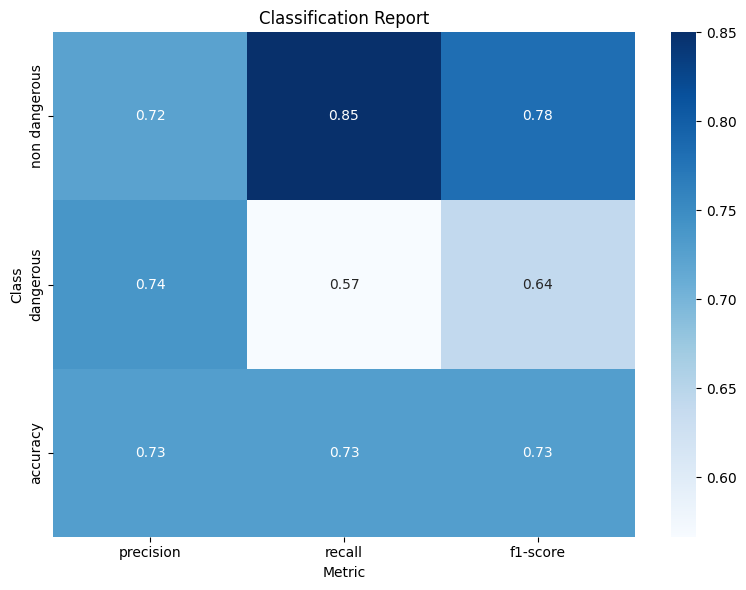

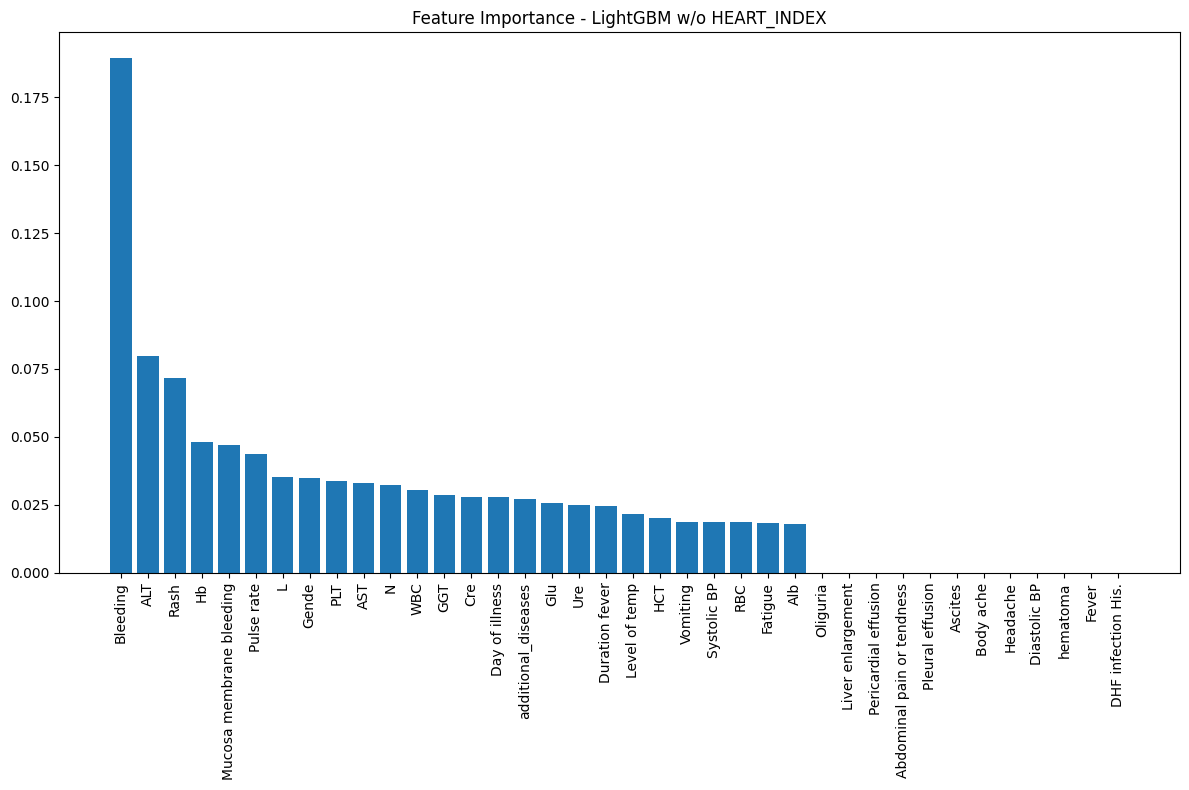

Features with zero importance: 12
['DHF infection His.', 'Fever', 'Diastolic BP', 'Headache', 'Body ache', 'hematoma', 'Pleural effusion', 'Ascites', 'Pericardial effusion', 'Abdominal pain or tendness'] ...


In [336]:
evaluate(xgb_model, x_test, y_test)
gain_importances_df = plot_feature_importance(xgb_model, features)

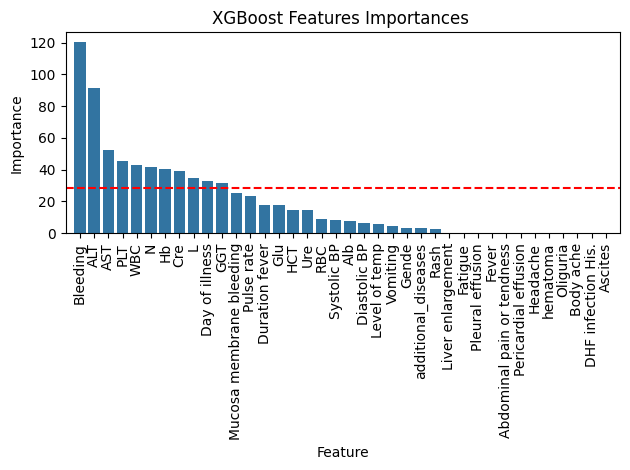

In [217]:
importance_df = xgb_model.get_booster().get_score(importance_type='total_gain')
    
mapped_importances = {features[int(k[1:])]: v for k, v in importance_df.items()}

mapped_importances_df = pd.DataFrame({
    'Feature': list(mapped_importances.keys()),
    'Importance': list(mapped_importances.values())
}).sort_values(by='Importance', ascending=False)


sns.barplot(y='Importance', x='Feature', data=mapped_importances_df)
plt.title("XGBoost Features Importances ")
plt.axhline(y=np.mean(mapped_importances_df['Importance']).item(), color='red', linestyle='--')
plt.xticks(range(x_train.shape[1]), list(features_arr[indices]), rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.show()

In [221]:
boruta = BorutaPy(
   estimator = xgb_model, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(Y))

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=np.float64(0.6), device=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, feature_weights=None,
                                 gamma=0.4, grow_policy=None,
                                 importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=0.269, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=26,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 multi_strategy=None, n_estimators=14,
                                 n_jobs=None, num_parallel_tree=None, ...),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x76DB34154140)

In [222]:
red_area = features_arr[boruta.support_]
pink_area = features_arr[boruta.support_weak_]
print('features in the red area:', red_area)
print('features in the pink area:', pink_area)

features in the red area: ['Bleeding' 'Mucosa membrane bleeding' 'AST']
features in the pink area: ['PLT' 'ALT']


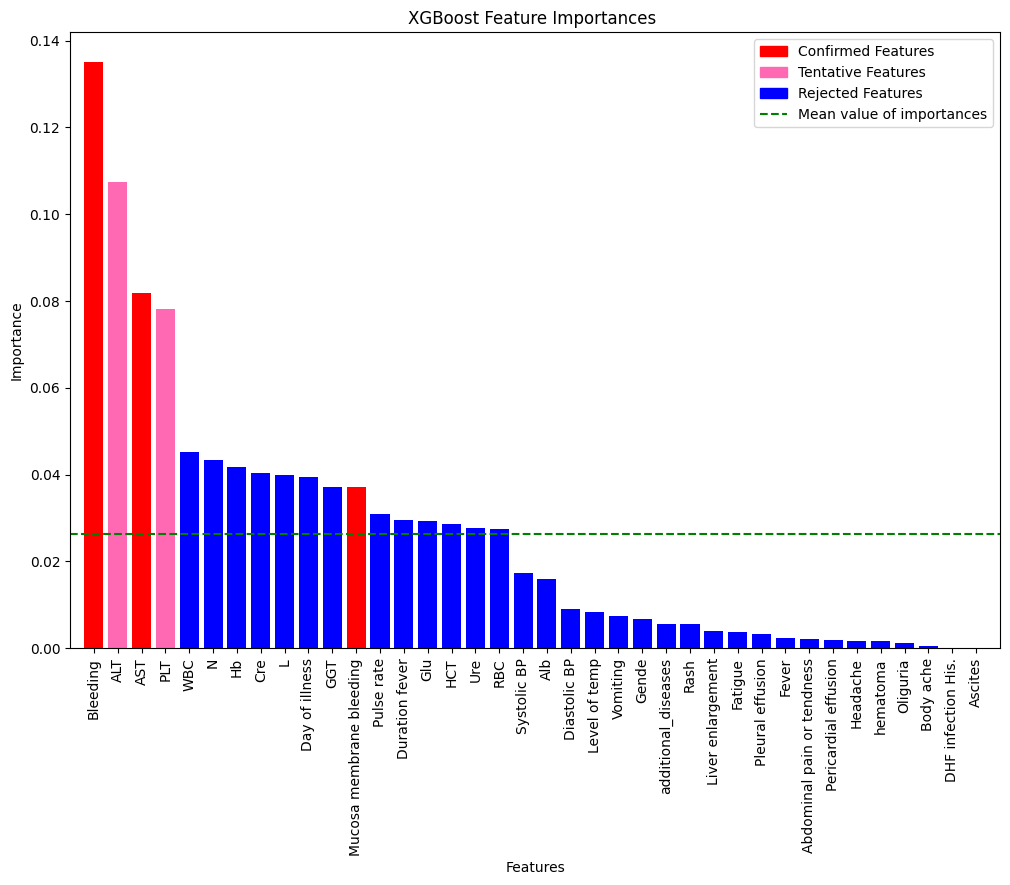

In [223]:
colors = np.asarray(['red' if cat in red_area else 'hotpink' if cat in pink_area else 'blue' for cat in features_arr])

# red_patch = mpatches.Patch(color='red', label='Type 1')
# blue_patch = mpatches.Patch(color='blue', label='Type 2')
# green_patch = mpatches.Patch(color='green', label='Type 3')

plt.figure(figsize=(12, 8))
plt.title("XGBoost Feature Importances ")
plt.bar(range(x_train.shape[1]), importances[indices], align="center", color=colors[indices])
plt.xticks(range(x_train.shape[1]), list(features_arr[indices]), rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.axhline(y=importances.mean(), color='g', linestyle='--')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.legend(handles=[mpatches.Patch(color='red', label='Confirmed Features'), mpatches.Patch(color='hotpink', label='Tentative Features'), mpatches.Patch(color='blue', label='Rejected Features'), \
                    Line2D([0], [0], color='green', linestyle='--', label='Mean value of importances')], loc='upper right')
plt.show()

In [337]:
xgb_proba = xgb_model.predict_proba(x_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, xgb_proba))

ROC AUC Score: 0.8133333333333334


In [220]:
y_pred = xgb_model.predict(x_test)
print(len(y_pred), len(y_test))

70 70


## LGBM

In [ ]:
import lightgbm as lgb

param_dist = {
    'num_leaves': randint(50, 500),
    'max_depth': randint(5, 50),
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'n_estimators': [50, 100, 200, 500],
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}


# # Initialize model
# lgbm = lgb.LGBMClassifier()

# Randomized search
random_search = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(),
    param_distributions=param_dist,
    n_iter=50,                # Number of parameter settings sampled
    scoring='accuracy',       # Or another metric
    cv=5,                     # 5-fold cross-validation
    verbose=0,
    random_state=42,
    n_jobs=-1                 # Use all available cores
)

# Fit on your data
random_search.fit(x_train, y_train)

In [227]:
random_search.best_params_

{'colsample_bytree': np.float64(1.0),
 'learning_rate': np.float64(0.01),
 'max_depth': 16,
 'n_estimators': 100,
 'num_leaves': 71,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': np.float64(0.6)}

In [338]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.01,  # Lower learning rate
    max_depth=16,         # Lower max depth
    # min_child_samples=5, # Require more samples in leaf nodes
    # min_child_weight=1,
    subsample=0.6,       # Use 80% of samples per tree
    colsample_bytree=1, # Use 80% of features per tree
    reg_alpha=0,       # L1 regularization
    reg_lambda=1,      # L2 regularization
    # random_state=42,
    verbose=-1           # Reduce verbosity
)

lgb_model.fit(x_train, y_train)


LGBMClassifier(colsample_bytree=1, learning_rate=0.01, max_depth=16,
               reg_alpha=0, reg_lambda=1, subsample=0.6, verbose=-1)

In [252]:
y_pred_lgb = lgb_model.predict(x_test)

print("LightGBM Report:\n", classification_report(np.asarray(y_test), np.asarray(y_pred_lgb)))

LightGBM Report:
               precision    recall  f1-score   support

         0.0       0.79      0.85      0.82        40
         1.0       0.78      0.70      0.74        30

    accuracy                           0.79        70
   macro avg       0.78      0.77      0.78        70
weighted avg       0.79      0.79      0.78        70



/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [342]:
lgb_proba = lgb_model.predict_proba(x_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, lgb_proba))

ROC AUC Score: 0.8004166666666667


/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


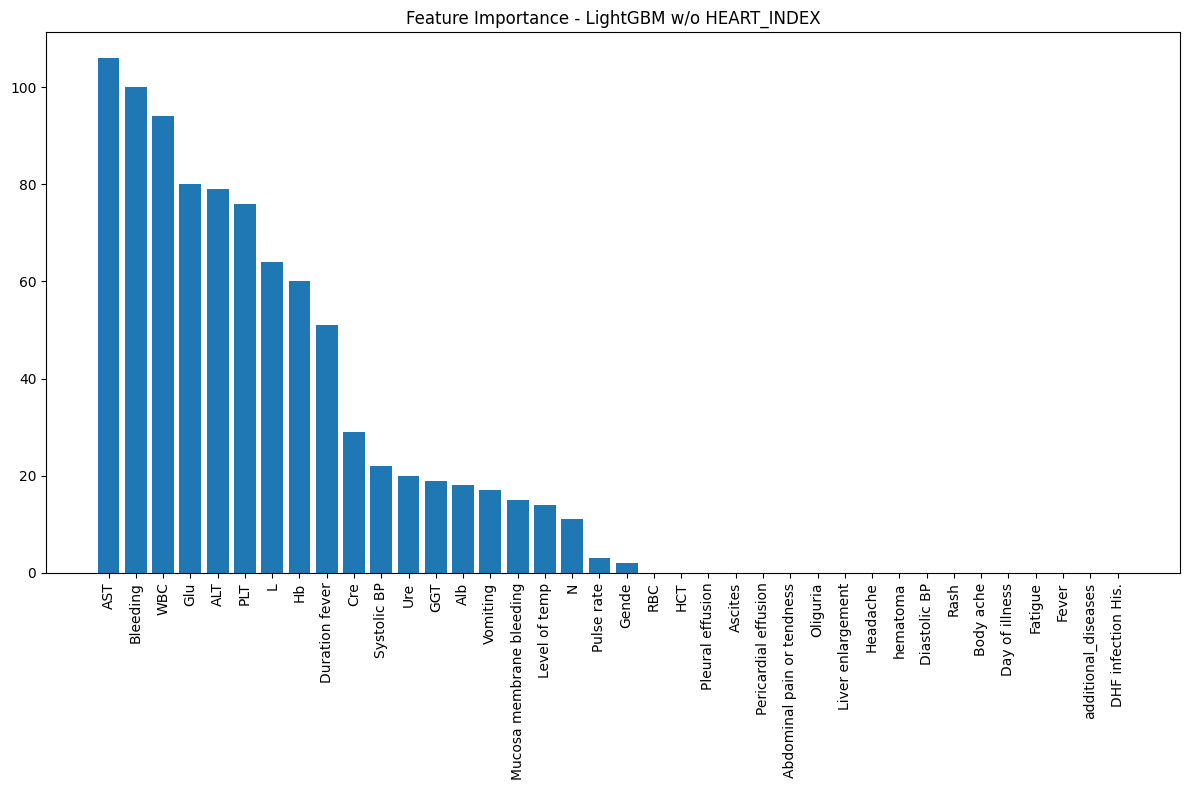

Features with zero importance: 18
['DHF infection His.', 'additional_diseases', 'Fever', 'Fatigue', 'Day of illness', 'Diastolic BP', 'Headache', 'Body ache', 'Rash', 'hematoma'] ...


In [253]:
def plot_feature_importance(model, feature_names):
    # Get feature importance
    importance = model.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importance)[::-1]
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance - LightGBM w/o HEART_INDEX')
    plt.bar(range(len(indices)), importance[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Return features with zero importance
    zero_features = [feature_names[i] for i, imp in enumerate(importance) if imp == 0]
    if zero_features:
        print(f"Features with zero importance: {len(zero_features)}")
        print(zero_features[:10], "..." if len(zero_features) > 10 else "")
    
    return indices, importance

# After training
feature_indices, importances = plot_feature_importance(lgb_model, features)

In [254]:
boruta = BorutaPy(
   estimator = lgb_model, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(Y))

red_area = features_arr[boruta.support_]
pink_area = features_arr[boruta.support_weak_]
print('features in the red area:', red_area)
print('features in the pink area:', pink_area)

features in the red area: ['PLT']
features in the pink area: []


In [257]:
y_pred

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [ ]:
# lgb_indices

array([0, 9, 1, 2, 6, 7, 3, 5, 8, 4])

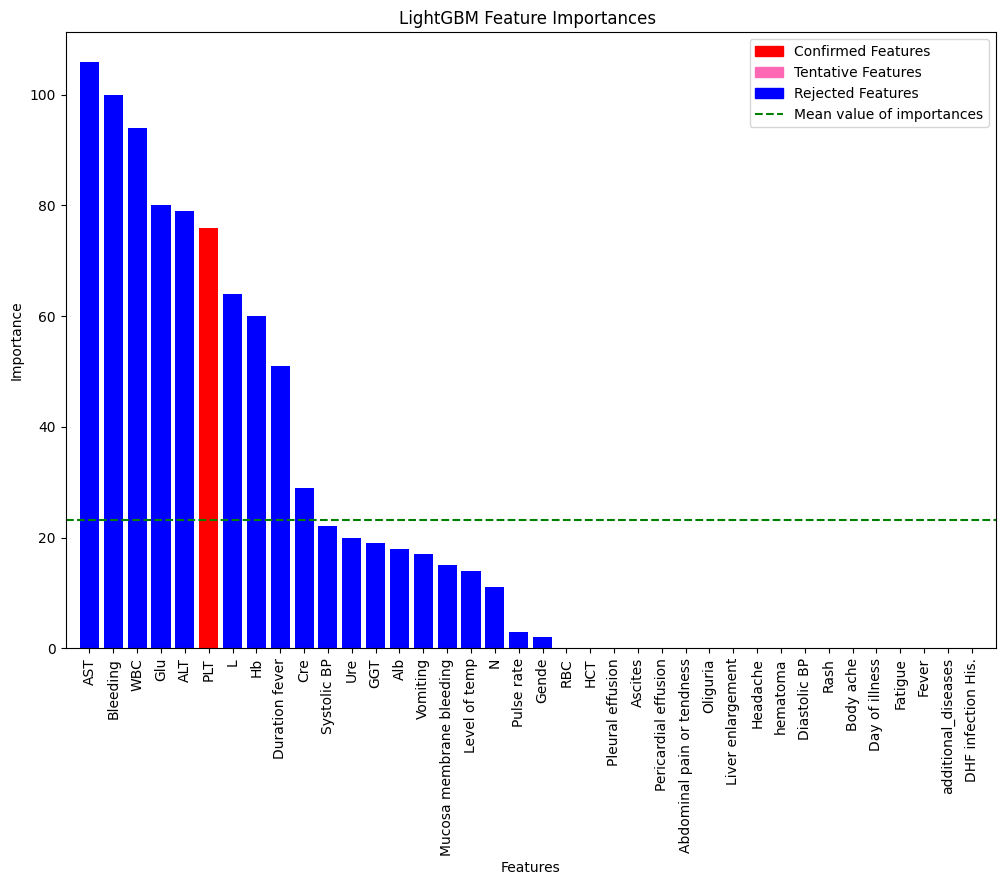

In [255]:
colors = np.asarray(['red' if cat in red_area else 'hotpink' if cat in pink_area else 'blue' for cat in features_arr])

# red_patch = mpatches.Patch(color='red', label='Type 1')
# blue_patch = mpatches.Patch(color='blue', label='Type 2')
# green_patch = mpatches.Patch(color='green', label='Type 3')

plt.figure(figsize=(12, 8))
plt.title("LightGBM Feature Importances ")
plt.bar(range(len(importances)), importances[feature_indices], align="center", color=colors[feature_indices])
plt.xticks(range(len(importances)), [str(features_arr[i]) for i in feature_indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.axhline(y=importances.mean(), color='g', linestyle='--')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.legend(handles=[mpatches.Patch(color='red', label='Confirmed Features'), mpatches.Patch(color='hotpink', label='Tentative Features'), mpatches.Patch(color='blue', label='Rejected Features'), \
                    Line2D([0], [0], color='green', linestyle='--', label='Mean value of importances')], loc='upper right')
plt.show()

## Extra Trees

In [343]:
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 25),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [False, True]
}

# Initialize model
et = ExtraTreesClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=et,
    param_distributions=param_dist,
    n_iter=50,                # Number of parameter settings sampled
    scoring='accuracy',       # Or another metric
    cv=5,                     # 5-fold cross-validation
    verbose=0,
    random_state=42,
    n_jobs=-1                 # Use all available cores
)

# Fit on your data
random_search.fit(x_train, y_train)

Process LokyProcess-117:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py", line 505, in _process_worker
    _process_reference_size = _get_memory_usage(pid, force_gc=True)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py", line 110, in _get_memory_usage
    gc.collect()
KeyboardInterrupt
Process LokyProcess-125:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.12/multiprocessing/process.py", line 108, in run
    s

KeyboardInterrupt: 

In [261]:
print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Best parameters found: {'bootstrap': True, 'max_depth': 44, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 17, 'n_estimators': 148}
Best cross-validation score: 0.7785714285714286


In [344]:
et_model = ExtraTreesClassifier(
    bootstrap=True,
    max_features='sqrt',
    n_estimators=148,
    max_depth=44,
    min_samples_split=17,
    min_samples_leaf=3      
)

et_model.fit(x_train, y_train)

ExtraTreesClassifier(bootstrap=True, max_depth=44, min_samples_leaf=3,
                     min_samples_split=17, n_estimators=148)

In [345]:
etr_proba = et_model.predict_proba(x_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, etr_proba))

ROC AUC Score: 0.8583333333333335


In [298]:
y_pred_et = et_model.predict(x_test)

print("ET Report:\n", classification_report(np.asarray(y_test), np.asarray(y_pred_et)))

ET Report:
               precision    recall  f1-score   support

         0.0       0.75      0.95      0.84        40
         1.0       0.89      0.57      0.69        30

    accuracy                           0.79        70
   macro avg       0.82      0.76      0.76        70
weighted avg       0.81      0.79      0.77        70



In [304]:
y_test

array([0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0.])

In [299]:
boruta = BorutaPy(
   estimator = et_model, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(Y))

red_area = features_arr[boruta.support_]
pink_area = features_arr[boruta.support_weak_]
print('features in the red area:', red_area)
print('features in the pink area:', pink_area)

features in the red area: ['Bleeding' 'Day of illness' 'Mucosa membrane bleeding' 'PLT' 'AST' 'ALT']
features in the pink area: ['Gende' 'additional_diseases' 'N' 'GGT']


In [300]:
et_importances = et_model.feature_importances_
et_indices = np.argsort(et_importances)[::-1]

In [302]:
et_importances.shape

(22,)

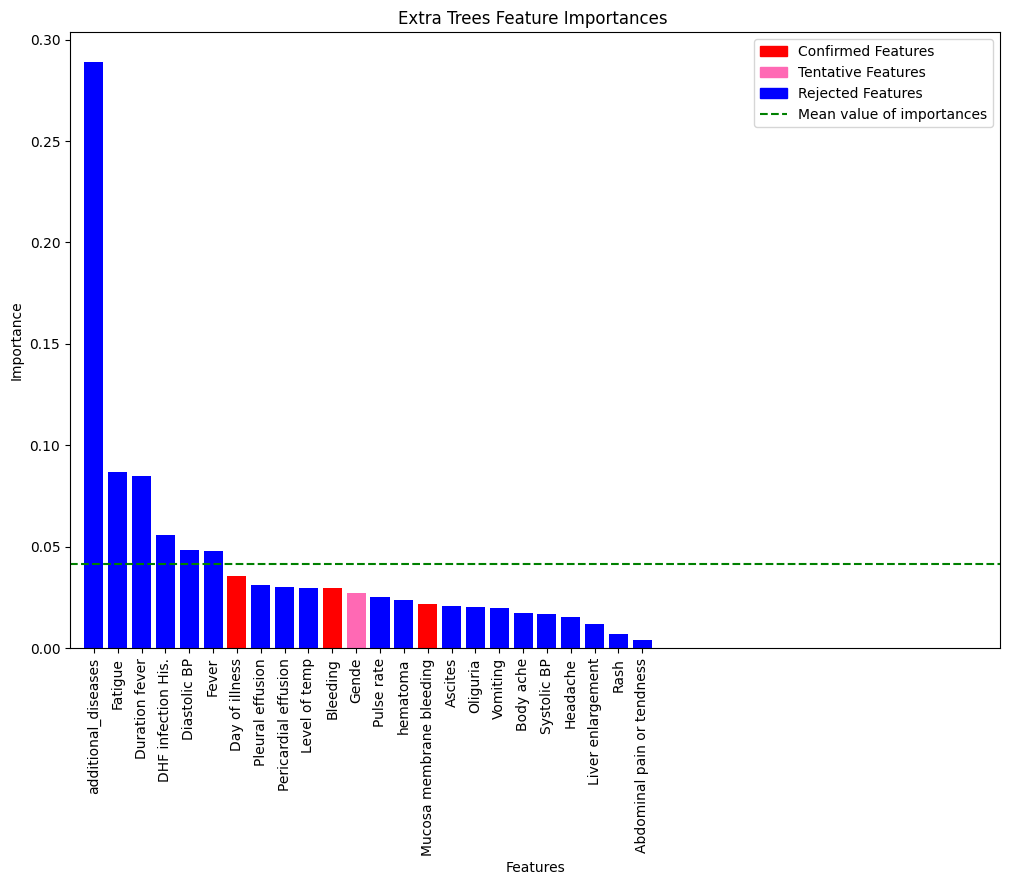

In [294]:
colors = np.asarray(['red' if cat in red_area else 'hotpink' if cat in pink_area else 'blue' for cat in features_arr])


# red_patch = mpatches.Patch(color='red', label='Type 1')
# blue_patch = mpatches.Patch(color='blue', label='Type 2')
# green_patch = mpatches.Patch(color='green', label='Type 3')

plt.figure(figsize=(12, 8))
plt.title("Extra Trees Feature Importances ")
plt.bar(range(len(et_indices)), et_importances[et_indices], align="center", color=colors[et_indices])
plt.xticks(range(len(et_indices)), [str(features_arr[i]) for i in et_indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
et_importances = et_model.feature_importances_
plt.axhline(y=et_importances.mean(), color='g', linestyle='--')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.legend(handles=[mpatches.Patch(color='red', label='Confirmed Features'), mpatches.Patch(color='hotpink', label='Tentative Features'), mpatches.Patch(color='blue', label='Rejected Features'), \
                    Line2D([0], [0], color='green', linestyle='--', label='Mean value of importances')], loc='upper right')
plt.show()

In [305]:
features

['Gende',
 'DHF infection His.',
 'additional_diseases',
 'Fever',
 'Bleeding',
 'Fatigue',
 'Day of illness',
 'Level of temp',
 'Duration fever',
 'Pulse rate',
 'Systolic BP',
 'Diastolic BP',
 'Headache',
 'Body ache',
 'Rash',
 'hematoma',
 'Mucosa membrane bleeding',
 'Pleural effusion',
 'Ascites',
 'Pericardial effusion',
 'Vomiting',
 'Abdominal pain or tendness',
 'Liver enlargement',
 'Oliguria',
 'WBC',
 'N',
 'L',
 'RBC',
 'Hb',
 'HCT',
 'PLT',
 'Glu',
 'Ure',
 'Cre',
 'Alb',
 'AST',
 'ALT',
 'GGT']

In [319]:
test = pd.DataFrame(X[:,20:], columns=features[20:])
test.describe()

,Vomiting,Abdominal pain or tendness,Liver enlargement,Oliguria,WBC,N,L,RBC,Hb,HCT,PLT,Glu,Ure,Cre,Alb,AST,ALT,GGT
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,0.180000,0.048571,0.037143,0.005714,4.509143,57.031971,26.485257,9.166486,132.142000,5.588383,102.491629,6.454829,3.848189,77.159714,18.311857,183.667143,103.810286,53.187171
std,0.384737,0.215278,0.189383,0.075485,4.275756,18.677790,15.267716,24.061905,29.292469,30.828572,64.167787,4.389173,5.807703,35.549429,20.392915,850.065259,306.141304,96.529881
min,0.000000,0.000000,0.000000,0.000000,1.100000,4.500000,2.100000,3.060000,0.300000,0.253000,1.300000,0.000000,0.000000,0.000000,0.000000,14.000000,8.400000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2.725000,44.000000,12.740000,4.300000,125.000000,0.374250,50.000000,5.235000,2.600000,67.100000,0.000000,35.325000,24.170000,11.400000
50%,0.000000,0.000000,0.000000,0.000000,3.700000,58.400000,25.335000,4.610000,136.000000,0.402000,98.000000,6.145000,3.615000,79.900000,0.000000,60.650000,45.400000,24.000000
75%,0.000000,0.000000,0.000000,0.000000,5.482500,72.775000,37.340000,5.067500,147.000000,0.440000,146.750000,7.637500,4.500000,95.000000,37.917500,123.825000,89.750000,52.425000
max,1.000000,1.000000,1.000000,1.000000,72.000000,90.100000,71.000000,162.000000,185.000000,283.000000,290.000000,67.230000,100.000000,417.000000,144.000000,15454.000000,5254.000000,998.110000
